In [200]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score, roc_auc_score
from sklearn.calibration import calibration_curve
import ast

import matplotlib
import matplotlib.patches as mpatches

# matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = "10"

In [410]:
plot_size = 5
small_plot_size = 3

In [561]:
outputs_dir = "../data/outputs"
        
def plot_roc_pr_curves(task):
    task_dir = os.path.join(outputs_dir, task)
    
    # Load data from files
    # train_df = pd.read_csv(os.path.join(task_dir, 'train_prediction.csv'))
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))

    # Create subplots
    # fig, axes = plt.subplots(2, 2, figsize=(2*plot_size, 2*plot_size))
    fig, axes = plt.subplots(1, 2, figsize=(2*plot_size, plot_size))
    axes = axes.flatten()
    
    # splits = ["Train", "Validation", "Test"]
    splits = ["Val", "Test"]

    # Plot ROC curves
    # for i, dataset_df in enumerate([train_df, val_df, test_df]):
    for i, dataset_df in enumerate([val_df, test_df]):
        ax = axes[i]

        # ROC curve
        fpr, tpr, _ = roc_curve(dataset_df['references'], dataset_df['prediction_scores'])
        roc_auc = auc(fpr, tpr)
        sns.lineplot(x=fpr, y=tpr, ax=ax, label=f'{task.upper()} ({splits[i]}\nAUC = {roc_auc:.4f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{task.upper()} {splits[i]} ROC Curve')

#     # Plot PR curves
#     # for i, dataset_df in enumerate([train_df, val_df, test_df]):
#     for i, dataset_df in enumerate([val_df, test_df]):
#         ax = axes[i + 2]

#         # PR curve
#         precision, recall, _ = precision_recall_curve(dataset_df['references'], dataset_df['prediction_scores'])
#         pr_auc = auc(recall, precision)
#         sns.lineplot(x=recall, y=precision, ax=ax, label=f'{task.upper()} ({splits[i]}\nAUC = {pr_auc:.4f})')
#         ax.set_xlim([0, 1])
#         ax.set_ylim([0, 1])
#         ax.set_xlabel('Recall')
#         ax.set_ylabel('Precision')
#         ax.set_title(f'{task.upper()} {splits[i]} PR Curve')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()
    
def plot_f1_scores_per_threshold(task):
    task_dir = os.path.join(outputs_dir, task)
    
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))
    _, _, thresholds = roc_curve(val_df['references'], val_df['prediction_scores'])
    
    f1_micro_scores_val = []
    f1_macro_scores_val = []
    f1_micro_scores_test = []
    f1_macro_scores_test = []

    for threshold in thresholds:
        # Calculate F1 scores for validation set
        predicted_classes_val = (val_df['prediction_scores'] >= threshold).astype(int)
        true_classes_val = val_df['references']
        f1_micro_scores_val.append(f1_score(true_classes_val, predicted_classes_val, average='micro'))
        f1_macro_scores_val.append(f1_score(true_classes_val, predicted_classes_val, average='macro'))

        # Calculate F1 scores for test set
        predicted_classes_test = (test_df['prediction_scores'] >= threshold).astype(int)
        true_classes_test = test_df['references']
        f1_micro_scores_test.append(f1_score(true_classes_test, predicted_classes_test, average='micro'))
        f1_macro_scores_test.append(f1_score(true_classes_test, predicted_classes_test, average='macro'))

    # Find the highest macro F1 scores and their corresponding thresholds
    max_f1_macro_val = max(f1_macro_scores_val)
    threshold_val = thresholds[f1_macro_scores_val.index(max_f1_macro_val)]
    adjusted_f1_micro_val = f1_score(val_df['references'], (val_df['prediction_scores'] >= threshold_val).astype(int), average='micro')
    adjusted_f1_micro_test = f1_score(test_df['references'], (test_df['prediction_scores'] >= threshold_val).astype(int), average='micro')
    adjusted_f1_macro_test = f1_score(test_df['references'], (test_df['prediction_scores'] >= threshold_val).astype(int), average='macro')
    
    # Plot F1 scores against thresholds
    plt.figure(figsize=(2*plot_size, small_plot_size+1))

    plt.subplot(1, 2, 1)
    # sns.lineplot(x=thresholds, y=f1_micro_scores_val, label='Validation Micro F1 Score')
    sns.lineplot(x=thresholds, y=f1_macro_scores_val, label=f'Best Val Threshold:{threshold_val:.4f}\nVal Macro F1: {max_f1_macro_val:.4f}')
    plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold = 0.5')
    # plt.scatter(threshold_val, adjusted_f1_micro_val, color='blue', marker='o', label=f'(Threshold: {threshold_val:.4f}) Micro F1: {adjusted_f1_micro_val:.4f}')
    plt.xlabel('Threshold')
    plt.ylabel('Macro F1 Score')
    plt.title(f'{task.upper()} Validation\nF1 Scores')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2)

    plt.subplot(1, 2, 2)
    # sns.lineplot(x=thresholds, y=f1_micro_scores_test, label='Test Micro F1 Score')
    # sns.lineplot(x=thresholds, y=f1_macro_scores_test, label='Test Macro F1 Score')
    sns.lineplot(x=thresholds, y=f1_macro_scores_test, label=f'Best Val Threshold:{threshold_val:.4f}\nTest Macro F1: {adjusted_f1_macro_test:.4f}')
    plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold = 0.5')
    # plt.scatter(threshold_val, adjusted_f1_micro_test, color='blue', marker='o', label=f'(Threshold: {threshold_val:.4f}) Micro F1: {adjusted_f1_micro_test:.4f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title(f'{task.upper()} Test\nF1 Scores')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2)

    plt.tight_layout()
    plt.show()
    

def plot_calibration_curve(task):
    task_dir = os.path.join(outputs_dir, task)
    
    # Load data from files
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))
    
    val_true_labels = val_df['references']
    val_predicted_probabilities = val_df['prediction_scores'].tolist()
    
    test_true_labels = test_df['references']
    test_predicted_probabilities = test_df['prediction_scores'].tolist()

    # Compute calibration curves for each split
    val_fraction_of_positives, val_mean_predicted_value = calibration_curve(val_true_labels, val_predicted_probabilities, n_bins=10)
    test_fraction_of_positives, test_mean_predicted_value = calibration_curve(test_true_labels, test_predicted_probabilities, n_bins=10)
    
    # Compute Expected Calibration Error (ECE) for each split
    val_ece = np.abs(val_mean_predicted_value - val_fraction_of_positives).mean()
    test_ece = np.abs(test_mean_predicted_value - test_fraction_of_positives).mean()

    # Create calibration plots using Seaborn's FacetGrid
    plt.figure(figsize=(2*plot_size, 2*small_plot_size))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Validation plot
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=val_mean_predicted_value, y=val_fraction_of_positives, color='C0', label='Data Points')
    sns.lineplot(x=val_mean_predicted_value, y=val_fraction_of_positives, color='C0', label='Calibration Curve')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'{task.upper()} Validation\nCalibration Plot\nECE: {val_ece:.4f}')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='best')
    plt.grid(True)

    # Test plot
    plt.subplot(2, 2, 2)
    sns.scatterplot(x=test_mean_predicted_value, y=test_fraction_of_positives, color='C1', label='Data Points')
    sns.lineplot(x=test_mean_predicted_value, y=test_fraction_of_positives, color='C1', label='Calibration Curve')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'{task.upper()} Test\nCalibration Plot\nECE: {test_ece:.4f}')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='best')
    plt.grid(True)
    
    # Mean Predicted Probability vs. Count
    plt.subplot(2, 2, 3)
    sns.histplot(val_predicted_probabilities, color='C0', linewidth=0, alpha=0.5, stat="density", kde=True, bins=20, element="step", label='Validation')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Density')
    # plt.title(f'{task.upper()} Validation\nMean Predicted Probability')
    plt.xlim([0, 1])
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    sns.histplot(test_predicted_probabilities, color='C1', linewidth=0, alpha=0.5, stat="density", kde=True, bins=20, element="step", label='Test')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Density')
    # plt.title(f'{task.upper()} Test\nMean Predicted Probability')
    plt.xlim([0, 1])
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

In [471]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import log_loss

class TemperatureScaling(nn.Module):
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

def temperature_calibrate_validation_set(task):
    task_dir = os.path.join(outputs_dir, task)
    
    # Load data from files
    val_logits = np.load(os.path.join(task_dir, 'val_logits.npy'))
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_logits = np.load(os.path.join(task_dir, 'test_logits.npy'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))
    
    val_true_labels = val_df['references']
    # val_predicted_probabilities = val_df['prediction_scores'].tolist()
    
    test_true_labels = test_df['references']
    # test_predicted_probabilities = test_df['prediction_scores'].tolist()

    # Get the device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Convert numpy arrays to PyTorch tensors and move to the appropriate device
    # val_predicted_probabilities = torch.tensor(val_predicted_probabilities, device=device).to(torch.float32)
    val_logits = torch.tensor(val_logits, device=device).to(torch.float32)
    val_true_labels = torch.tensor(val_true_labels, device=device).to(torch.long)

    # test_predicted_probabilities = torch.tensor(test_predicted_probabilities, device=device).to(torch.float32)
    test_logits = torch.tensor(test_logits, device=device).to(torch.float32)
    test_true_labels = torch.tensor(test_true_labels, device=device).to(torch.long)

    # Define the temperature scaling model and move it to the appropriate device
    model = TemperatureScaling().to(device)

    # Define the CrossEntropyLoss criterion
    criterion = nn.CrossEntropyLoss()

    # Define the LBFGS optimizer
    optimizer = optim.LBFGS([model.temperature], lr=0.001, max_iter=100, line_search_fn="strong_wolfe")

    # Define the closure function for LBFGS
    def closure():
        optimizer.zero_grad()
        loss = criterion(model(val_logits), val_true_labels)
        loss.backward()
        return loss

    # Optimize the temperature using LBFGS
    optimizer.step(closure)

    # Apply temperature scaling to the logits for both validation and test sets
    calibrated_val_logits = model(val_logits)
    calibrated_test_logits = model(test_logits)
    
    calibrated_val_logits = F.softmax(calibrated_val_logits, dim=1).cpu().detach().numpy()
    calibrated_test_logits = F.softmax(calibrated_test_logits, dim=1).cpu().detach().numpy()
    
    # calibrated_val_logits = calibrated_val_logits.cpu().detach().numpy()
    # calibrated_test_logits = calibrated_test_logits.cpu().detach().numpy()

    # Compute calibration curves for the validation and test sets
    val_fraction_of_positives, val_mean_predicted_value = calibration_curve(val_true_labels.cpu().numpy(), calibrated_val_logits[:,-1], n_bins=10)
    val_ece = np.abs(val_mean_predicted_value - val_fraction_of_positives).mean()

    test_fraction_of_positives, test_mean_predicted_value = calibration_curve(test_true_labels.cpu().numpy(), calibrated_test_logits[:,-1], n_bins=10)
    test_ece = np.abs(test_mean_predicted_value - test_fraction_of_positives).mean()

#     # Compute AUROC
#     val_auroc = roc_auc_score(val_true_labels.cpu().numpy(), calibrated_val_logits[:,-1])
#     test_auroc = roc_auc_score(test_true_labels.cpu().numpy(), calibrated_test_logits[:,-1])
    
#     print("val_auroc: ", val_auroc)
#     print("test_auroc: ", test_auroc)
    
    # Create calibration plots for both validation and test sets
    plt.figure(figsize=(2*plot_size, 2*small_plot_size))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.subplot(2, 2, 1)
    sns.scatterplot(x=val_mean_predicted_value, y=val_fraction_of_positives, color='C0', label='Data Points')
    sns.lineplot(x=val_mean_predicted_value, y=val_fraction_of_positives, color='C0', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'{task.upper()} Validation\nCalibration Plot\nECE: {val_ece:.4f}')
    # plt.title(f'{task.upper()} Validation\nCalibration Plot\nECE: {val_ece:.4f}\nMCE: {val_mce:.4f}')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='best')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.scatterplot(x=test_mean_predicted_value, y=test_fraction_of_positives, color='C1', label='Data Points')
    sns.lineplot(x=test_mean_predicted_value, y=test_fraction_of_positives, color='C1', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'{task.upper()} Test\nCalibration Plot\nECE: {test_ece:.4f}')
    # plt.title(f'{task.upper()} Test\nCalibration Plot\nECE: {test_ece:.4f}\nMCE: {test_mce:.4f}')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='best')
    plt.grid(True)
    
    # Mean Predicted Probability vs. Count
    plt.subplot(2, 2, 3)
    sns.histplot(val_mean_predicted_value, color='C0', linewidth=0, alpha=0.5, stat="density", kde=True, bins=10, element="step", label='Validation')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Density')
    # plt.title(f'{task.upper()} Validation\nMean Predicted Probability')
    plt.xlim([0, 1])
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    sns.histplot(test_mean_predicted_value, color='C1', linewidth=0, alpha=0.5, stat="density", kde=True, bins=10, element="step", label='Test')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Density')
    # plt.title(f'{task.upper()} Test\nMean Predicted Probability')
    plt.xlim([0, 1])
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

    return model.temperature.item()


def lr_calibrate_validation_set(task):
    task_dir = os.path.join(outputs_dir, task)

    # Load data from files
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))

    val_true_labels = val_df['references']
    val_predicted_probabilities = val_df['prediction_scores'].tolist()
    
    test_true_labels = test_df['references']
    test_predicted_probabilities = test_df['prediction_scores'].tolist()

    # Train a base estimator on the validation set
    calibration_model = LogisticRegression(fit_intercept=True, max_iter=100000, random_state=1234)
    calibration_model.fit(np.array(val_predicted_probabilities).reshape(-1,1), np.array(val_true_labels))

    # Compute calibration curves for the validation set
    val_calibrated_prediction = calibration_model.predict_proba(np.array(val_predicted_probabilities).reshape(-1,1))[:, -1]
    val_fraction_of_positives, val_mean_predicted_value = calibration_curve(val_true_labels, val_calibrated_prediction, n_bins=10)
    val_ece = np.abs(val_mean_predicted_value - val_fraction_of_positives).mean()
    
    test_calibrated_prediction = calibration_model.predict_proba(np.array(test_predicted_probabilities).reshape(-1,1))[:, -1]
    test_fraction_of_positives, test_mean_predicted_value = calibration_curve(test_true_labels, test_calibrated_prediction, n_bins=10)
    test_ece = np.abs(test_mean_predicted_value - test_fraction_of_positives).mean()

#     # Compute AUROC
#     val_auroc = roc_auc_score(val_true_labels, val_calibrated_prediction)
#     test_auroc = roc_auc_score(test_true_labels, test_calibrated_prediction)
    
#     print("val_auroc: ", val_auroc)
#     print("test_auroc: ", test_auroc)

    # Create calibration plot
    plt.figure(figsize=(2*plot_size, 2*small_plot_size))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.subplot(2, 2, 1)
    sns.scatterplot(x=val_mean_predicted_value, y=val_fraction_of_positives, color='C0', label='Data Points')
    sns.lineplot(x=val_mean_predicted_value, y=val_fraction_of_positives, color='C0', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'{task.upper()} Validation\nCalibration Plot\nECE: {val_ece:.4f}')
    # plt.title(f'{task.upper()} Validation\nCalibration Plot\nECE: {val_ece:.4f}\nAUROC: {val_auroc:.4f}')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='best')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.scatterplot(x=test_mean_predicted_value, y=test_fraction_of_positives, color='C0', label='Data Points')
    sns.lineplot(x=test_mean_predicted_value, y=test_fraction_of_positives, color='C0', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'{task.upper()} Test\nCalibration Plot\nECE: {test_ece:.4f}')
    # plt.title(f'{task.upper()} Test\nCalibration Plot\nECE: {test_ece:.4f}\nAUROC: {test_auroc:.4f}')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='best')
    plt.grid(True)
    
    # Mean Predicted Probability vs. Count
    plt.subplot(2, 2, 3)
    sns.histplot(val_mean_predicted_value, color='blue', linewidth=0, alpha=0.5, stat="density", kde=True, bins=10, element="step", label='Validation')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Density')
    # plt.title(f'{task.upper()} Validation\nMean Predicted Probability')
    plt.xlim([0, 1])
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    sns.histplot(test_mean_predicted_value, color='green', linewidth=0, alpha=0.5, stat="density", kde=True, bins=10, element="step", label='Test')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Density')
    # plt.title(f'{task.upper()} Test\nMean Predicted Probability')
    plt.xlim([0, 1])
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

    return calibration_model

def lr_logits_calibrate_validation_set(task):
    task_dir = os.path.join(outputs_dir, task)

    # Load data from files
    val_logits = np.load(os.path.join(task_dir, 'val_logits.npy'))
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_logits = np.load(os.path.join(task_dir, 'test_logits.npy'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))

    val_true_labels = val_df['references']
    val_predicted_probabilities = val_df['prediction_scores'].tolist()
    
    test_true_labels = test_df['references']
    test_predicted_probabilities = test_df['prediction_scores'].tolist()

    # Train a base estimator on the validation set
    calibration_model = LogisticRegression(random_state=1234)
    calibration_model.fit(val_logits, np.array(val_true_labels))

    # Compute calibration curves for the validation set
    val_calibrated_prediction = calibration_model.predict_proba(val_logits)[:, -1]
    val_fraction_of_positives, val_mean_predicted_value = calibration_curve(val_true_labels, val_calibrated_prediction, n_bins=10)
    val_ece = np.abs(val_mean_predicted_value - val_fraction_of_positives).mean()
    
    test_calibrated_prediction = calibration_model.predict_proba(test_logits)[:, -1]
    test_fraction_of_positives, test_mean_predicted_value = calibration_curve(test_true_labels, test_calibrated_prediction, n_bins=10)
    test_ece = np.abs(test_mean_predicted_value - test_fraction_of_positives).mean()

#     # Compute AUROC
#     val_auroc = roc_auc_score(val_true_labels, val_calibrated_prediction)
#     test_auroc = roc_auc_score(test_true_labels, test_calibrated_prediction)
    
#     print("val_auroc: ", val_auroc)
#     print("test_auroc: ", test_auroc)

    # Create calibration plot
    plt.figure(figsize=(2*plot_size, 2*small_plot_size))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.subplot(2, 2, 1)
    sns.scatterplot(x=val_mean_predicted_value, y=val_fraction_of_positives, color='C0', label='Data Points')
    sns.lineplot(x=val_mean_predicted_value, y=val_fraction_of_positives, color='C0', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'{task.upper()} Validation\nCalibration Plot\nECE: {val_ece:.4f}')
    # plt.title(f'{task.upper()} Validation\nCalibration Plot\nECE: {val_ece:.4f}\nAUROC: {val_auroc:.4f}')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='best')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.scatterplot(x=test_mean_predicted_value, y=test_fraction_of_positives, color='C1', label='Data Points')
    sns.lineplot(x=test_mean_predicted_value, y=test_fraction_of_positives, color='C1', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'{task.upper()} Test\nCalibration Plot\nECE: {test_ece:.4f}')
    # plt.title(f'{task.upper()} Test\nCalibration Plot\nECE: {test_ece:.4f}\nAUROC: {test_auroc:.4f}')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc='best')
    plt.grid(True)
    
    # Mean Predicted Probability vs. Count
    plt.subplot(2, 2, 3)
    sns.histplot(val_mean_predicted_value, color='C0', linewidth=0, alpha=0.5, stat="density", kde=True, bins=10, element="step", label='Validation')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Density')
    # plt.title(f'{task.upper()} Validation\nMean Predicted Probability')
    plt.xlim([0, 1])
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    sns.histplot(test_mean_predicted_value, color='C1', linewidth=0, alpha=0.5, stat="density", kde=True, bins=10, element="step", label='Test')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Density')
    # plt.title(f'{task.upper()} Test\nMean Predicted Probability')
    plt.xlim([0, 1])
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

    return calibration_model

# PMV

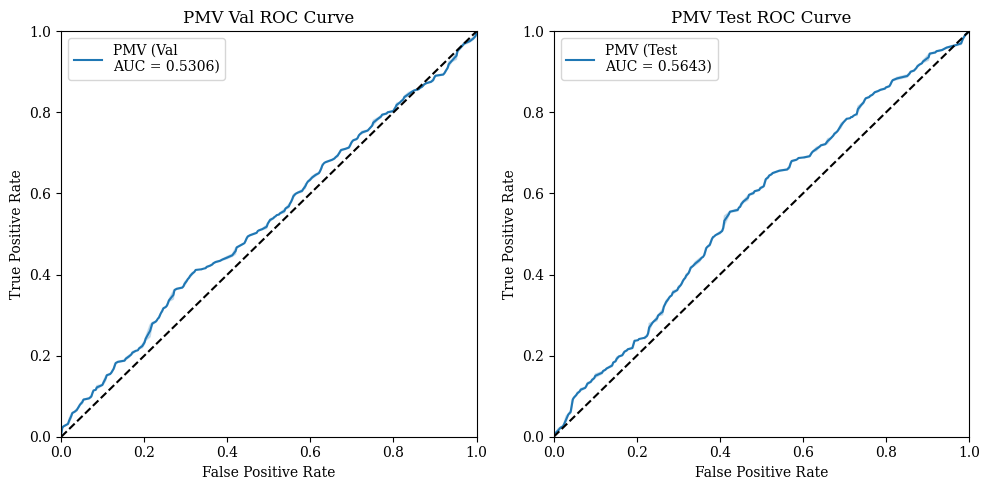

In [31]:
plot_roc_pr_curves("pmv")

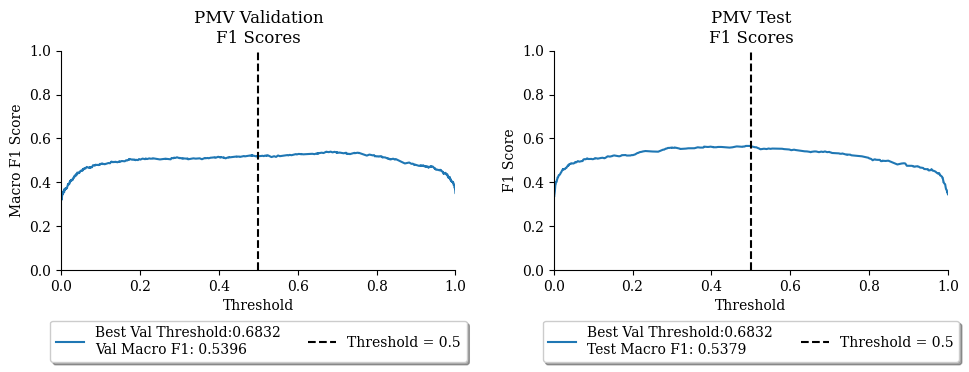

In [562]:
plot_f1_scores_per_threshold("pmv")

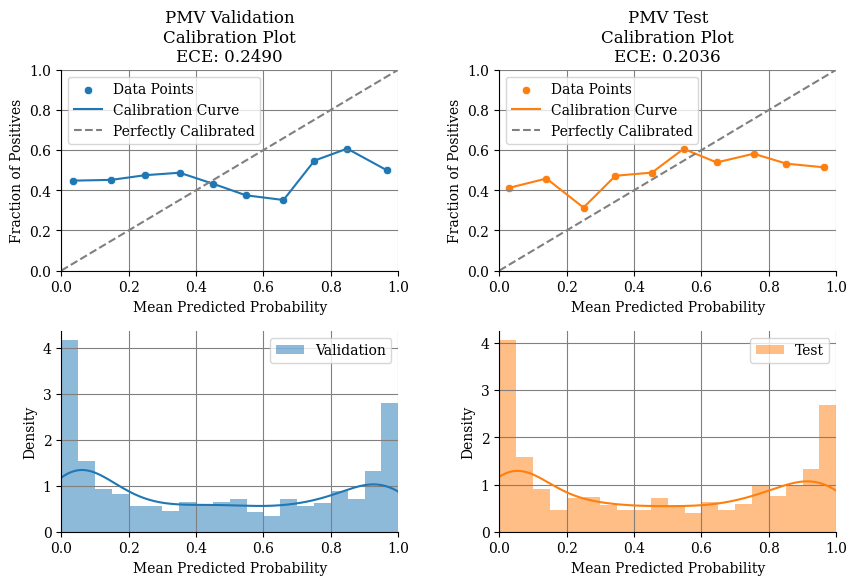

In [477]:
plot_calibration_curve("pmv")

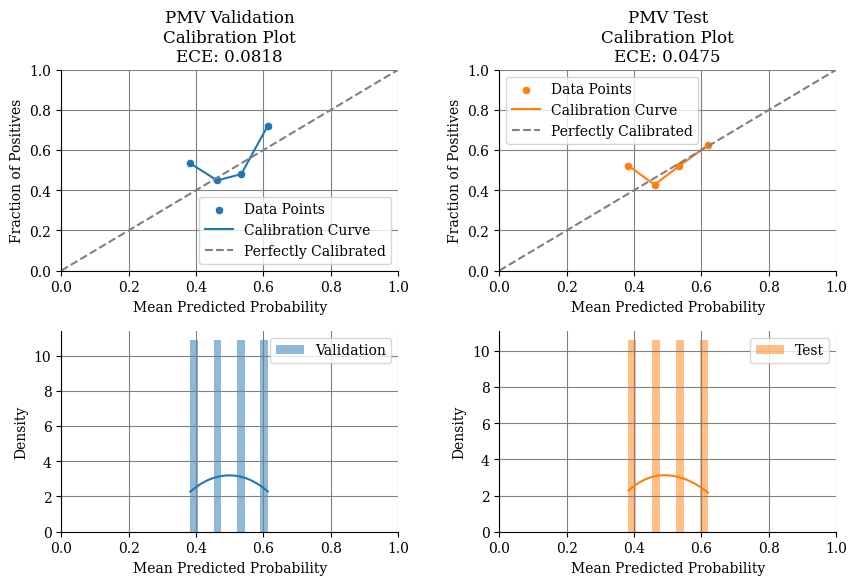

15.411751747131348

In [473]:
temperature_calibrate_validation_set("pmv")

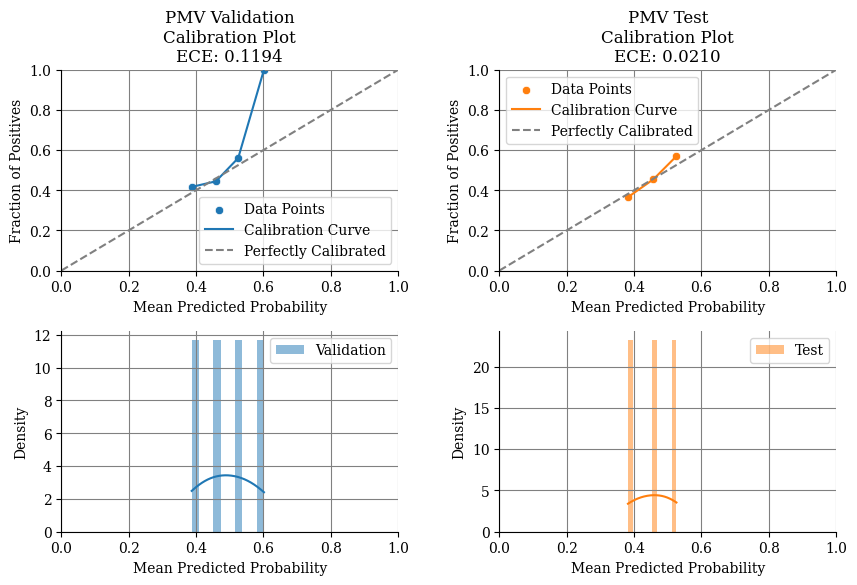

LogisticRegression(random_state=1234)

In [474]:
lr_logits_calibrate_validation_set("pmv")

# MOR

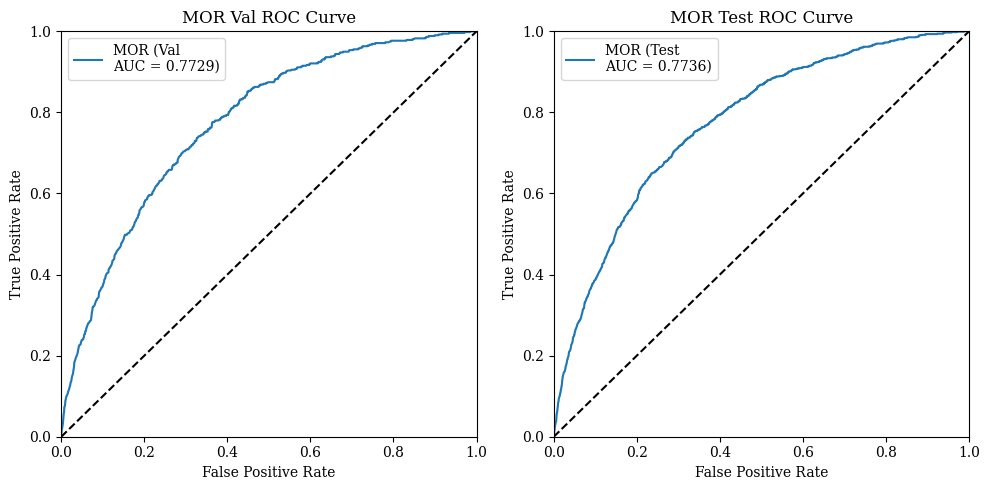

In [32]:
plot_roc_pr_curves("mor")

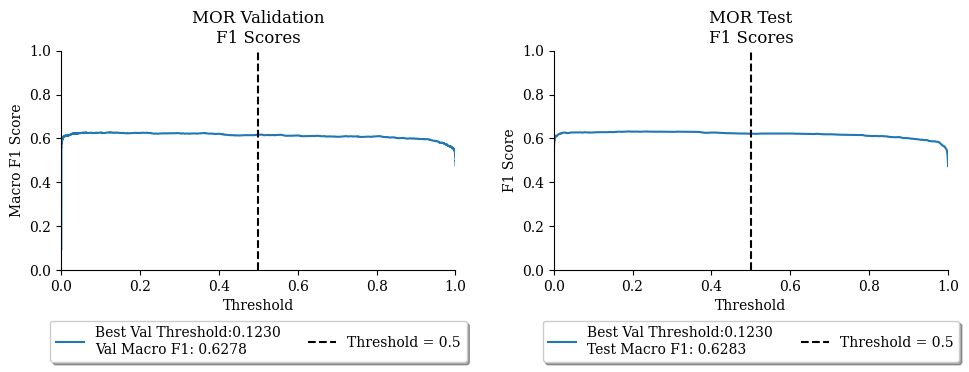

In [563]:
plot_f1_scores_per_threshold("mor")

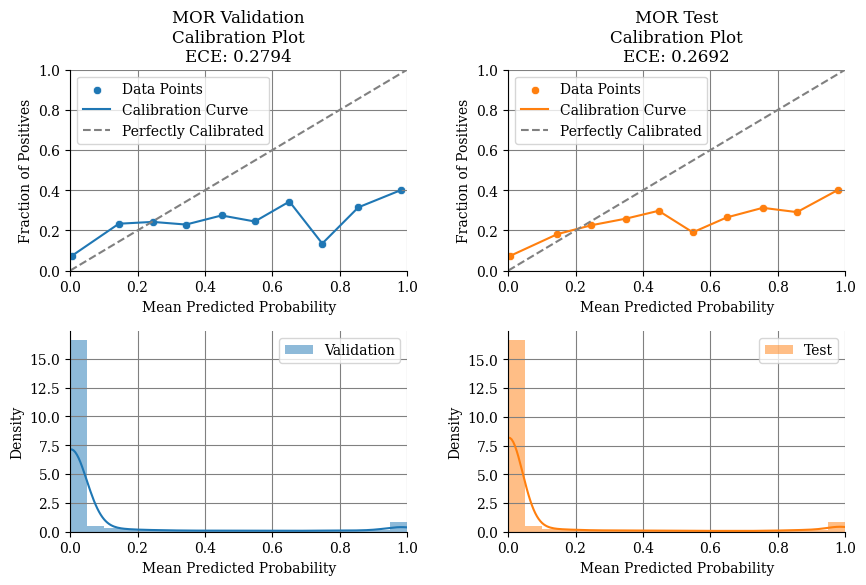

In [478]:
plot_calibration_curve("mor")

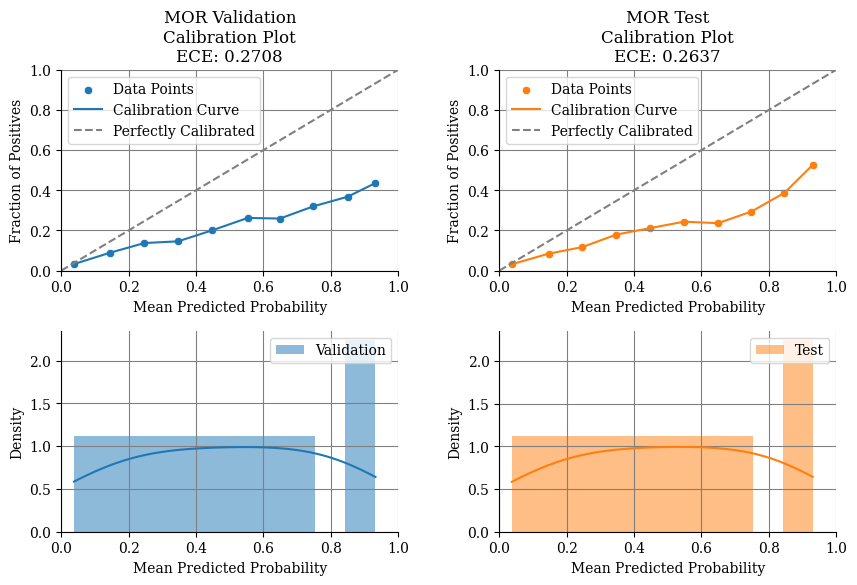

4.525883674621582

In [479]:
temperature_calibrate_validation_set("mor")

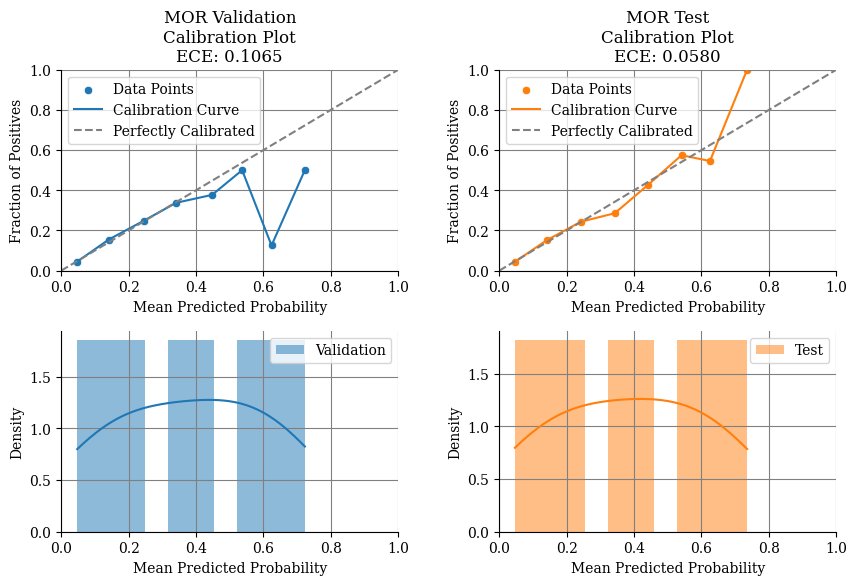

LogisticRegression(random_state=1234)

In [480]:
lr_logits_calibrate_validation_set("mor")

# MULTICLASS TASKS (LOS)

In [568]:
import numpy as np
from sklearn.preprocessing import label_binarize
from itertools import cycle
import ast

def plot_multiclass_roc_pr_curves(task, class_ids=None, class_names=None, multilabel=False):
    task_dir = os.path.join(outputs_dir, task)
    
    # Load data from files
    # train_df = pd.read_csv(os.path.join(task_dir, 'train_prediction.csv'))
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))

    # Determine the number of classes
    if multilabel:
        num_classes = len(ast.literal_eval(val_df['prediction_scores'][0]))
    else:
        num_classes = len(val_df['references'].unique())
    
    # Binarize the labels
    if multilabel:
        # train_true_labels = np.array(train_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
        val_true_labels = np.array(val_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
        test_true_labels = np.array(test_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
    else:
        # train_true_labels = label_binarize(train_df['references'], classes=range(num_classes))
        val_true_labels = label_binarize(val_df['references'], classes=range(num_classes))
        test_true_labels = label_binarize(test_df['references'], classes=range(num_classes))

    # If class_ids is not None, select only the specified class IDs
    if class_ids is None:
        class_ids = list(range(num_classes))
    else:
        # train_true_labels = train_true_labels[:, class_ids]
        val_true_labels = val_true_labels[:, class_ids]
        test_true_labels = test_true_labels[:, class_ids]
        num_classes = len(class_ids)

    # Create subplots
    # fig, axes = plt.subplots(2, 2, figsize=(2*plot_size, 2*plot_size))
    fig, axes = plt.subplots(1, 2, figsize=(2*plot_size, 1*plot_size))
    axes = axes.flatten()

    # Plot ROC curves and PR curves
    # datasets = [('Train', train_df, train_true_labels), ('Validation', val_df, val_true_labels), ('Test', test_df, test_true_labels)]
    datasets = [('Val', val_df, val_true_labels), ('Test', test_df, test_true_labels)]
    thresholds_list = []

    for i, (dataset_name, dataset_df, true_labels) in enumerate(datasets):
        ax1 = axes[i]
        ax2 = axes[i + 2]

        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        dataset_scores = np.array(dataset_df['prediction_scores'].apply(lambda x: ast.literal_eval(x)).tolist())

        for class_id in range(num_classes):
            class_label = class_ids[class_id]
            class_scores = dataset_scores[:, class_label]
            fpr[class_label], tpr[class_label], _ = roc_curve(true_labels[:, class_id], class_scores)
            roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

        # Compute PR curve and AUC for each class
        precision = dict()
        recall = dict()
        pr_auc = dict()

        for class_id in range(num_classes):
            class_label = class_ids[class_id]
            class_scores = dataset_scores[:, class_label]
            precision[class_label], recall[class_label], _ = precision_recall_curve(true_labels[:, class_id], class_scores)
            pr_auc[class_label] = auc(recall[class_label], precision[class_label])

        # Plot ROC curves for each class
        for class_id in range(num_classes):
            class_label = class_ids[class_id]
            class_name = class_names[class_id]
            ax1.plot(fpr[class_label], tpr[class_label], color=f'C{class_id}', lw=2,
                     label=f'Class "{class_name}" (AUC = {roc_auc[class_label]:.4f})')

        ax1.plot([0, 1], [0, 1], 'k--')
        ax1.set_xlim([0, 1])
        ax1.set_ylim([0, 1])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title(f'{task.upper()} {dataset_name}\nROC Curves')
        ax1.legend(loc="lower right")
        # ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

#         # Plot PR curves for each class
#         for class_id in range(num_classes):
#             class_label = class_ids[class_id]
#             class_name = class_names[class_id]
#             ax2.plot(recall[class_label], precision[class_label], color=f'C{class_id}', lw=2,
#                      label=f'Class "{class_name}" (AUC = {pr_auc[class_label]:.4f})')

#         ax2.set_xlim([0, 1])
#         ax2.set_ylim([0, 1])
#         ax2.set_xlabel('Recall')
#         ax2.set_ylabel('Precision')
#         ax2.set_title(f'{task.upper()} {dataset_name}\nPR Curves')
#         ax2.legend(loc="lower right")
#         # ax2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.tight_layout()
    plt.show()


def plot_multiclass_f1_scores_per_threshold(task, class_ids=None, class_names=None, multilabel=False):
    task_dir = os.path.join(outputs_dir, task)
    
    # Load data from files
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))
    
    val_scores = np.array(val_df['prediction_scores'].apply(lambda x: ast.literal_eval(x)).tolist())
    test_scores = np.array(test_df['prediction_scores'].apply(lambda x: ast.literal_eval(x)).tolist())
    
    # Determine the number of classes
    if multilabel:
        num_classes = len(ast.literal_eval(val_df['prediction_scores'][0]))
    else:
        num_classes = len(val_df['references'].unique())
    
    # Binarize the labels
    if multilabel:
        val_true_labels = np.array(val_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
        test_true_labels = np.array(test_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
    else:
        val_true_labels = label_binarize(val_df['references'], classes=range(num_classes))
        test_true_labels = label_binarize(test_df['references'], classes=range(num_classes))
        
    # If class_ids is not None, select only the specified class IDs
    if class_ids is None:
        class_ids = list(range(num_classes))
    else:
        num_classes = len(class_ids)

    # Compute F1 scores for different thresholds
    f1_macro_scores_val = [[] for _ in range(num_classes)]
    f1_macro_scores_test = [[] for _ in range(num_classes)]
    thresholds = [[] for _ in range(num_classes)]
    best_threshold_val = [0.5] * num_classes
    best_f1_macro_val = [0.0] * num_classes

    for class_id in range(num_classes):
        class_label = class_ids[class_id]
        fpr, tpr, class_thresholds = roc_curve(val_true_labels[:, class_label], val_scores[:, class_label])

        for threshold in class_thresholds:
            val_predicted_labels = (val_scores[:, class_label] >= threshold).astype(int)
            test_predicted_labels = (test_scores[:, class_label] >= threshold).astype(int)
            f1_macro_scores_val[class_id].append(f1_score(val_true_labels[:, class_label], val_predicted_labels, average="macro"))
            f1_macro_scores_test[class_id].append(f1_score(test_true_labels[:, class_label], test_predicted_labels, average="macro"))
            thresholds[class_id].append(threshold)
        
        # Find the highest macro F1 score and its corresponding threshold from the validation set
        max_f1_macro_val = max(f1_macro_scores_val[class_id])
        threshold_val = thresholds[class_id][f1_macro_scores_val[class_id].index(max_f1_macro_val)]
        best_f1_macro_val[class_id] = max_f1_macro_val
        best_threshold_val[class_id] = threshold_val

    # Plot F1 scores for each split
    # plt.figure()
    fig, ax = plt.subplots(ncols=2, figsize=(2*plot_size, plot_size+2))

    # Validation plot
    # plt.subplot(1, 2, 1)
    class_patches_val = []
    for class_id in range(num_classes):
        class_label = class_ids[class_id]
        class_name = class_names[class_id]
        ax[0].plot(thresholds[class_id], f1_macro_scores_val[class_id], label=f'Macro F1 - {class_name}')
        class_patches_val += [mpatches.Patch(color=f'C{class_id}', label=f'Class "{class_name}"\nBest Val Threshold:{best_threshold_val[class_id]:.4f}\nVal Macro F1: {max(f1_macro_scores_val[class_id]):.4f}')]
    ax[0].axvline(x=0.5, color='black', linestyle='--', label='Threshold = 0.5', alpha=0.5)
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('Macro F1 Score')
    ax[0].set_title(f'{task.upper()} Validation\nF1 Scores per Threshold')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1])
    ax[0].legend(handles=class_patches_val, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
        
    
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=2)

    # Test plot
    # plt.subplot(1, 2, 2)
    class_patches_test = []
    for class_id in range(num_classes):
        class_label = class_ids[class_id]
        class_name = class_names[class_id]
        ax[1].plot(thresholds[class_id], f1_macro_scores_test[class_id], label=f'Macro F1 - {class_name}')
        class_patches_test += [mpatches.Patch(color=f'C{class_id}', label=f'Class "{class_name}"\nBest Val Threshold:{best_threshold_val[class_id]:.4f}\nTest Macro F1: {max(f1_macro_scores_test[class_id]):.4f}')]
    ax[1].axvline(x=0.5, color='black', linestyle='--', label='Threshold = 0.5', alpha=0.5)
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('Macro F1 Score')
    ax[1].set_title(f'{task.upper()} Test\nF1 Scores per Threshold')
    ax[1].set_xlim([0, 1])
    ax[1].set_ylim([0, 1])
    ax[1].legend(handles=class_patches_test, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)
    
    plt.tight_layout()
    plt.show()

def plot_multiclass_calibration_curve(task, class_ids=None, class_names=None, multilabel=False, to_plot=True):
    task_dir = os.path.join(outputs_dir, task)
    
    # Load data from files
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))
    
    # Determine the number of classes
    if multilabel:
        num_classes = len(ast.literal_eval(val_df['prediction_scores'][0]))
    else:
        num_classes = len(val_df['references'].unique())
    
    # Extract true labels and predicted probabilities for each split
    if multilabel:
        val_true_labels = np.array(val_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
        test_true_labels = np.array(test_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
    else:
        val_true_labels = label_binarize(val_df['references'], classes=range(num_classes))
        test_true_labels = label_binarize(test_df['references'], classes=range(num_classes))
        
    val_predicted_probabilities = np.array(val_df['prediction_scores'].apply(lambda x: ast.literal_eval(x)).tolist())
    test_predicted_probabilities = np.array(test_df['prediction_scores'].apply(lambda x: ast.literal_eval(x)).tolist())
    
    # If class_ids is not None, select only the specified class IDs
    if class_ids is None:
        class_ids = list(range(num_classes))
    else:
        num_classes = len(class_ids)

    # Compute calibration curves for each class and each split
    val_fraction_of_positives = {class_id: [] for class_id in class_ids}
    val_mean_predicted_value = {class_id: [] for class_id in class_ids}
    val_ece = {class_id: [] for class_id in class_ids}
    test_fraction_of_positives = {class_id: [] for class_id in class_ids}
    test_mean_predicted_value = {class_id: [] for class_id in class_ids}
    test_ece = {class_id: [] for class_id in class_ids}
    thresholds = {class_id: [] for class_id in class_ids}

    for class_id in range(num_classes):
        class_label = class_ids[class_id]
        # Compute calibration curves for each split
        val_fraction_of_positives[class_label], val_mean_predicted_value[class_label] = calibration_curve(val_true_labels[:, class_label], val_predicted_probabilities[:, class_label], n_bins=10)
        test_fraction_of_positives[class_label], test_mean_predicted_value[class_label] = calibration_curve(test_true_labels[:, class_label], test_predicted_probabilities[:, class_label], n_bins=10)
        
        # Compute Expected Calibration Error (ECE) for each split
        val_ece[class_label] = np.abs(val_mean_predicted_value[class_label] - val_fraction_of_positives[class_label]).mean()
        test_ece[class_label] = np.abs(test_mean_predicted_value[class_label] - test_fraction_of_positives[class_label]).mean()
    
    if to_plot:
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(4*small_plot_size, 2*small_plot_size))

        for class_id in range(num_classes):
            class_label = class_ids[class_id]
            class_name = class_names[class_id]
            # Validation plot
            sns.scatterplot(x=val_mean_predicted_value[class_label], y=val_fraction_of_positives[class_label], label=f'Class "{class_name}" - Val ECE: {val_ece[class_label]:.4f}', ax=ax[0][0])
            sns.lineplot(x=val_mean_predicted_value[class_label], y=val_fraction_of_positives[class_label], color=f'C{class_id}', ax=ax[0][0])
            ax[0][0].set_xlabel('Mean Predicted Probability')
            ax[0][0].set_ylabel('Fraction of Positives')
            ax[0][0].set_title(f'{task.upper()} Validation\nMulticlass Calibration Plot')
            ax[0][0].set_xlim([0, 1])
            ax[0][0].set_ylim([0, 1])
            ax[0][0].legend(loc='best')
            ax[0][0].grid(True)

            # Test plot
            sns.scatterplot(x=test_mean_predicted_value[class_label], y=test_fraction_of_positives[class_label], label=f'Class "{class_name}" - Test ECE: {test_ece[class_label]:.4f}', ax=ax[0][1])
            sns.lineplot(x=test_mean_predicted_value[class_label], y=test_fraction_of_positives[class_label], color=f'C{class_id}', ax=ax[0][1])
            ax[0][1].set_xlabel('Mean Predicted Probability')
            ax[0][1].set_ylabel('Fraction of Positives')
            ax[0][1].set_title(f'{task.upper()} Test\nMulticlass Calibration Plot')
            ax[0][1].set_xlim([0, 1])
            ax[0][1].set_ylim([0, 1])
            ax[0][1].legend(loc='best')
            ax[0][1].grid(True)

        ax[0][0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
        ax[0][1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

        # # Mean Predicted Probability vs. Count
        # fig, ax = plt.subplots(ncols=2, figsize=(4*small_plot_size, small_plot_size))

        for class_id in range(num_classes):
            class_label = class_ids[class_id]
            class_name = class_names[class_id]
            sns.histplot(val_predicted_probabilities[:, class_label], color=f'C{class_id}', linewidth=0, alpha=0.5, label=f'Class "{class_name}"', stat="density", kde=True, bins=20, element="step", ax=ax[1][0])
            ax[1][0].set_xlabel('Mean Predicted Probability')
            ax[1][0].set_ylabel('Density')
            # ax[1][0].set_title(f'{task.upper()} Validation\nMean Predicted Probability vs. Density\nClass "{class_name}"')
            ax[1][0].set_xlim([0, 1])
            ax[1][0].legend(loc='upper right')
            ax[1][0].grid(True)

            sns.histplot(test_predicted_probabilities[:, class_label], color=f'C{class_id}', linewidth=0, alpha=0.5, label=f'Class "{class_name}"', stat="density", kde=True, bins=20, element="step", ax=ax[1][1])
            ax[1][1].set_xlabel('Mean Predicted Probability')
            ax[1][1].set_ylabel('Density')
            # ax[1][1].set_title(f'{task.upper()} Test\nMean Predicted Probability vs. Density\nClass "{class_name}"')
            ax[1][1].set_xlim([0, 1])
            ax[1][1].legend(loc='upper right')
            ax[1][1].grid(True)

        plt.show()
        
    mean_val_ece = sum(val_ece.values()) / len(val_ece)
    mean_test_ece = sum(test_ece.values()) / len(test_ece)
    print(f"mean_val_ece: {mean_val_ece}")
    print(f"mean_test_ece: {mean_test_ece}")

In [496]:
colors = ["blue", "orange", "green", "red", "purple"]

In [483]:
def lr_calibrate_multiclass_validation_set(task, class_ids=None, class_names=None, multilabel=False, to_plot=True):
    task_dir = os.path.join(outputs_dir, task)

    # Load data from files
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))

    # Determine the number of classes
    if multilabel:
        num_classes = len(ast.literal_eval(val_df['prediction_scores'][0]))
    else:
        num_classes = len(val_df['references'].unique())

    # Extract true labels and predicted probabilities for each split
    if multilabel:
        val_true_labels = np.array(val_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
        test_true_labels = np.array(test_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
    else:
        val_true_labels = label_binarize(val_df['references'], classes=range(num_classes))
        test_true_labels = label_binarize(test_df['references'], classes=range(num_classes))

    val_predicted_probabilities = np.array(val_df['prediction_scores'].apply(lambda x: ast.literal_eval(x)).tolist())
    test_predicted_probabilities = np.array(test_df['prediction_scores'].apply(lambda x: ast.literal_eval(x)).tolist())

    # If class_ids is not None, select only the specified class IDs
    if class_ids is None:
        class_ids = list(range(num_classes))
    else:
        num_classes = len(class_ids)

    # Compute calibration curves for each class and each split
    val_fraction_of_positives = {class_id: [] for class_id in class_ids}
    val_mean_predicted_value = {class_id: [] for class_id in class_ids}
    val_ece = {class_id: [] for class_id in class_ids}
    test_fraction_of_positives = {class_id: [] for class_id in class_ids}
    test_mean_predicted_value = {class_id: [] for class_id in class_ids}
    test_ece = {class_id: [] for class_id in class_ids}
    thresholds = {class_id: [] for class_id in class_ids}

    for class_id in class_ids:
        # Train a base estimator on the validation set
        calibration_model = LogisticRegression()
        calibration_model.fit(np.array(val_predicted_probabilities[:, class_id]).reshape(-1, 1), val_true_labels[:, class_id])

        # Compute calibration curves for each split
        val_calibrated_prediction = calibration_model.predict_proba(np.array(val_predicted_probabilities[:, class_id]).reshape(-1, 1))[:, 1]
        val_fraction_of_positives[class_id], val_mean_predicted_value[class_id] = calibration_curve(
            val_true_labels[:, class_id], val_calibrated_prediction, n_bins=10
        )

        test_calibrated_prediction = calibration_model.predict_proba(np.array(test_predicted_probabilities[:, class_id]).reshape(-1, 1))[:, 1]
        test_fraction_of_positives[class_id], test_mean_predicted_value[class_id] = calibration_curve(
            test_true_labels[:, class_id], test_calibrated_prediction, n_bins=10
        )

        # Compute Expected Calibration Error (ECE) for each split
        val_ece[class_id] = np.abs(val_mean_predicted_value[class_id] - val_fraction_of_positives[class_id]).mean()
        test_ece[class_id] = np.abs(test_mean_predicted_value[class_id] - test_fraction_of_positives[class_id]).mean()

    # Create calibration plots
    fig, ax = plt.subplots(ncols=2, figsize=(2 * plot_size, small_plot_size))
    for idx, class_id in enumerate(class_ids):
        class_name = class_names[idx] if class_names else f'Class {idx}'

        # Validation plot
        sns.scatterplot(
            x=val_mean_predicted_value[class_id],
            y=val_fraction_of_positives[class_id],
            # color=f'{colors[idx]}',
            color=f"C{idx}",
            label=f'{class_name}\nVal ECE: {val_ece[class_id]:.4f}',
            ax=ax[0],
        )
        sns.lineplot(
            x=val_mean_predicted_value[class_id],
            y=val_fraction_of_positives[class_id],
            # color=f'{colors[idx]}',
            color=f"C{idx}",
            ax=ax[0],
        )
        ax[0].set_xlabel('Mean Predicted Probability')
        ax[0].set_ylabel('Fraction of Positives')
        ax[0].set_title(f'{task.upper()} Validation\nMulticlass Calibration Plot')
        ax[0].set_xlim([0, 1])
        ax[0].set_ylim([0, 1])
        ax[0].legend(loc='best')
        ax[0].grid(True)

        # Test plot
        sns.scatterplot(
            x=test_mean_predicted_value[class_id],
            y=test_fraction_of_positives[class_id],
            # color=f'{colors[idx]}',
            color=f"C{idx}",
            label=f'{class_name}\nTest ECE: {test_ece[class_id]:.4f}',
            ax=ax[1],
        )
        sns.lineplot(
            x=test_mean_predicted_value[class_id],
            y=test_fraction_of_positives[class_id],
            # color=f'{colors[idx]}',
            color=f"C{idx}",
            ax=ax[1],
        )
        ax[1].set_xlabel('Mean Predicted Probability')
        ax[1].set_ylabel('Fraction of Positives')
        ax[1].set_title(f'{task.upper()} Test\nMulticlass Calibration Plot')
        ax[1].set_xlim([0, 1])
        ax[1].set_ylim([0, 1])
        ax[1].legend(loc='best')
        ax[1].grid(True)

    ax[0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

    plt.show()

In [537]:
def lr_logits_calibrate_multiclass_validation_set(task, class_ids=None, class_names=None, multilabel=False, to_plot=True):
    task_dir = os.path.join(outputs_dir, task)

    # Load data from files
    val_logits = np.load(os.path.join(task_dir, 'val_logits.npy'))
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_logits = np.load(os.path.join(task_dir, 'test_logits.npy'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))

    # Determine the number of classes
    if multilabel:
        num_classes = len(ast.literal_eval(val_df['prediction_scores'][0]))
    else:
        num_classes = len(val_df['references'].unique())

    # Extract true labels and predicted probabilities for each split
    if multilabel:
        val_true_labels = np.array(val_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
        test_true_labels = np.array(test_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
    else:
        val_true_labels = label_binarize(val_df['references'], classes=range(num_classes))
        test_true_labels = label_binarize(test_df['references'], classes=range(num_classes))

    # If class_ids is not None, select only the specified class IDs
    if class_ids is None:
        class_ids = list(range(num_classes))
    else:
        num_classes = len(class_ids)

    # Compute calibration curves for each class and each split
    val_fraction_of_positives = {class_id: [] for class_id in class_ids}
    val_mean_predicted_value = {class_id: [] for class_id in class_ids}
    val_ece = {class_id: [] for class_id in class_ids}
    test_fraction_of_positives = {class_id: [] for class_id in class_ids}
    test_mean_predicted_value = {class_id: [] for class_id in class_ids}
    test_ece = {class_id: [] for class_id in class_ids}
    thresholds = {class_id: [] for class_id in class_ids}

    for class_id in class_ids:
        try:
            # Train a base estimator on the validation set
            calibration_model = LogisticRegression()
            calibration_model.fit(np.array(val_logits[:, class_id]).reshape(-1, 1), val_true_labels[:, class_id])

            # Compute calibration curves for each split
            val_calibrated_prediction = calibration_model.predict_proba(np.array(val_logits[:, class_id]).reshape(-1, 1))[:, 1]
            val_fraction_of_positives[class_id], val_mean_predicted_value[class_id] = calibration_curve(
                val_true_labels[:, class_id], val_calibrated_prediction, n_bins=10
            )

            test_calibrated_prediction = calibration_model.predict_proba(np.array(test_logits[:, class_id]).reshape(-1, 1))[:, 1]
            test_fraction_of_positives[class_id], test_mean_predicted_value[class_id] = calibration_curve(
                test_true_labels[:, class_id], test_calibrated_prediction, n_bins=10
            )

            # Compute Expected Calibration Error (ECE) for each split
            val_ece[class_id] = np.abs(val_mean_predicted_value[class_id] - val_fraction_of_positives[class_id]).mean()
            test_ece[class_id] = np.abs(test_mean_predicted_value[class_id] - test_fraction_of_positives[class_id]).mean()
        except ValueError:
            # Because the class doesn't have a positive class, remove from ECE computation
            val_ece[class_id] = 0
            test_ece[class_id] = 0
            # del val_ece[class_id]
            # del test_ece[class_id]

    
    if to_plot:
        # Create calibration plots
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(4*small_plot_size, 2*small_plot_size))
        for idx, class_id in enumerate(class_ids):
            class_name = class_names[idx] if class_names else f'Class {idx}'

            # Validation plot
            sns.scatterplot(
                x=val_mean_predicted_value[class_id],
                y=val_fraction_of_positives[class_id],
                # color=f'{colors[idx]}',
                color=f"C{idx}",
                label=f'{class_name} - Val ECE: {val_ece[class_id]:.4f}',
                ax=ax[0][0],
            )
            sns.lineplot(
                x=val_mean_predicted_value[class_id],
                y=val_fraction_of_positives[class_id],
                # color=f'{colors[idx]}',
                color=f"C{idx}",
                ax=ax[0][0],
            )
            ax[0][0].set_xlabel('Mean Predicted Probability')
            ax[0][0].set_ylabel('Fraction of Positives')
            ax[0][0].set_title(f'{task.upper()} Validation\nMulticlass Calibration Plot')
            ax[0][0].set_xlim([0, 1])
            ax[0][0].set_ylim([0, 1])
            ax[0][0].legend(loc='best')
            ax[0][0].grid(True)

            # Test plot
            sns.scatterplot(
                x=test_mean_predicted_value[class_id],
                y=test_fraction_of_positives[class_id],
                # color=f'{colors[idx]}',
                color=f"C{idx}",
                label=f'{class_name} - Test ECE: {test_ece[class_id]:.4f}',
                ax=ax[0][1],
            )
            sns.lineplot(
                x=test_mean_predicted_value[class_id],
                y=test_fraction_of_positives[class_id],
                # color=f'{colors[idx]}',
                color=f"C{idx}",
                ax=ax[0][1],
            )
            ax[0][1].set_xlabel('Mean Predicted Probability')
            ax[0][1].set_ylabel('Fraction of Positives')
            ax[0][1].set_title(f'{task.upper()} Test\nMulticlass Calibration Plot')
            ax[0][1].set_xlim([0, 1])
            ax[0][1].set_ylim([0, 1])
            ax[0][1].legend(loc='best')
            ax[0][1].grid(True)

        ax[0][0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
        ax[0][1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

        # Mean Predicted Probability vs. Count
        # fig, ax = plt.subplots(ncols=2, figsize=(4*small_plot_size, small_plot_size))
        for idx, class_id in enumerate(class_ids):
            class_name = class_names[idx] if class_names else f'Class {idx}'
            sns.histplot(val_mean_predicted_value[class_id], color=f'C{idx}', linewidth=0, alpha=0.5, label=f'Class "{class_name}"', stat="density", kde=True, bins=20, element="step", ax=ax[1][0])
            ax[1][0].set_xlabel('Mean Predicted Probability')
            ax[1][0].set_ylabel('Density')
            # ax[1][0].set_title(f'{task.upper()} Validation\nMean Predicted Probability vs. Density\nClass "{class_name}"')
            ax[1][0].set_xlim([0, 1])
            ax[1][0].legend(loc='upper right')
            ax[1][0].grid(True)

            sns.histplot(test_mean_predicted_value[class_id], color=f'C{idx}', linewidth=0, alpha=0.5, label=f'Class "{class_name}"', stat="density", kde=True, bins=20, element="step", ax=ax[1][1])
            ax[1][1].set_xlabel('Mean Predicted Probability')
            ax[1][1].set_ylabel('Density')
            # ax[1][1].set_title(f'{task.upper()} Test\nMean Predicted Probability vs. Density\nClass "{class_name}"')
            ax[1][1].set_xlim([0, 1])
            ax[1][1].legend(loc='upper right')
            ax[1][1].grid(True)

        plt.show()
    
    mean_val_ece = sum(val_ece.values()) / len(val_ece)
    mean_test_ece = sum(test_ece.values()) / len(test_ece)
    print(f"mean_val_ece: {mean_val_ece}")
    print(f"mean_test_ece: {mean_test_ece}")

In [527]:
def temperature_logits_calibrate_multiclass_validation_set(task, class_ids=None, class_names=None, multilabel=False, to_plot=True):
    task_dir = os.path.join(outputs_dir, task)
    
    # Load data from files
    val_logits = np.load(os.path.join(task_dir, 'val_logits.npy'))
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_logits = np.load(os.path.join(task_dir, 'test_logits.npy'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))

    # Determine the number of classes
    if multilabel:
        num_classes = len(ast.literal_eval(val_df['prediction_scores'][0]))
    else:
        num_classes = len(val_df['references'].unique())

    # Extract true labels and predicted probabilities for each split
    if multilabel:
        val_true_labels = np.array(val_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
        test_true_labels = np.array(test_df['references'].apply(lambda x: ast.literal_eval(x)).tolist())
    else:
        val_true_labels = label_binarize(val_df['references'], classes=range(num_classes))
        test_true_labels = label_binarize(test_df['references'], classes=range(num_classes))
        
    # If class_ids is not None, select only the specified class IDs
    if class_ids is None:
        class_ids = list(range(num_classes))
    else:
        num_classes = len(class_ids)

    # Get the device (CPU or GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Convert numpy arrays to PyTorch tensors and move to the appropriate device
    # val_predicted_probabilities = torch.tensor(val_predicted_probabilities, device=device).to(torch.float32)
    val_logits = torch.tensor(val_logits, device=device).to(torch.float32)
    val_true_labels = torch.tensor(val_true_labels, device=device).to(torch.float32)

    # test_predicted_probabilities = torch.tensor(test_predicted_probabilities, device=device).to(torch.float32)
    test_logits = torch.tensor(test_logits, device=device).to(torch.float32)
    test_true_labels = torch.tensor(test_true_labels, device=device).to(torch.float32)

    # Define the temperature scaling model and move it to the appropriate device
    model = TemperatureScaling().to(device)

    # Define the CrossEntropyLoss criterion
    criterion = nn.CrossEntropyLoss()

    # Define the LBFGS optimizer
    optimizer = optim.LBFGS([model.temperature], lr=0.001, max_iter=100, line_search_fn="strong_wolfe")

    # Define the closure function for LBFGS
    def closure():
        optimizer.zero_grad()
        loss = criterion(model(val_logits), val_true_labels)
        loss.backward()
        return loss

    # Optimize the temperature using LBFGS
    optimizer.step(closure)

    # Apply temperature scaling to the logits for both validation and test sets
    calibrated_val_logits = model(val_logits)
    calibrated_test_logits = model(test_logits)
    
    calibrated_val_logits = F.softmax(calibrated_val_logits, dim=1).cpu().detach().numpy()
    calibrated_test_logits = F.softmax(calibrated_test_logits, dim=1).cpu().detach().numpy()
    
    # calibrated_val_logits = calibrated_val_logits.cpu().detach().numpy()
    # calibrated_test_logits = calibrated_test_logits.cpu().detach().numpy()

#     # Compute calibration curves for the validation and test sets
#     val_fraction_of_positives, val_mean_predicted_value = calibration_curve(val_true_labels.cpu().numpy(), calibrated_val_logits[:,-1], n_bins=10)
#     val_ece = np.abs(val_mean_predicted_value - val_fraction_of_positives).mean()

#     test_fraction_of_positives, test_mean_predicted_value = calibration_curve(test_true_labels.cpu().numpy(), calibrated_test_logits[:,-1], n_bins=10)
#     test_ece = np.abs(test_mean_predicted_value - test_fraction_of_positives).mean()

    # Compute calibration curves for each class and each split
    val_fraction_of_positives = {class_id: [] for class_id in class_ids}
    val_mean_predicted_value = {class_id: [] for class_id in class_ids}
    val_ece = {class_id: [] for class_id in class_ids}
    test_fraction_of_positives = {class_id: [] for class_id in class_ids}
    test_mean_predicted_value = {class_id: [] for class_id in class_ids}
    test_ece = {class_id: [] for class_id in class_ids}
    thresholds = {class_id: [] for class_id in class_ids}

    for class_id in class_ids:
        # Compute calibration curves for each split
        val_fraction_of_positives[class_id], val_mean_predicted_value[class_id] = calibration_curve(
            val_true_labels[:, class_id], calibrated_val_logits[:, class_id], n_bins=10
        )
        test_fraction_of_positives[class_id], test_mean_predicted_value[class_id] = calibration_curve(
            test_true_labels[:, class_id], calibrated_test_logits[:, class_id], n_bins=10
        )

        # Compute Expected Calibration Error (ECE) for each split
        val_ece[class_id] = np.abs(val_mean_predicted_value[class_id] - val_fraction_of_positives[class_id]).mean()
        test_ece[class_id] = np.abs(test_mean_predicted_value[class_id] - test_fraction_of_positives[class_id]).mean()

    if to_plot:
        # Create calibration plots
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(4*small_plot_size, 2*small_plot_size))
        for idx, class_id in enumerate(class_ids):
            class_name = class_names[idx] if class_names else f'Class {idx}'

            # Validation plot
            sns.scatterplot(
                x=val_mean_predicted_value[class_id],
                y=val_fraction_of_positives[class_id],
                # color=f'{colors[idx]}',
                color=f"C{idx}",
                label=f'{class_name} - Val ECE: {val_ece[class_id]:.4f}',
                ax=ax[0][0],
            )
            sns.lineplot(
                x=val_mean_predicted_value[class_id],
                y=val_fraction_of_positives[class_id],
                # color=f'{colors[idx]}',
                color=f"C{idx}",
                ax=ax[0][0],
            )
            ax[0][0].set_xlabel('Mean Predicted Probability')
            ax[0][0].set_ylabel('Fraction of Positives')
            ax[0][0].set_title(f'{task.upper()} Validation\nMulticlass Calibration Plot')
            ax[0][0].set_xlim([0, 1])
            ax[0][0].set_ylim([0, 1])
            ax[0][0].legend(loc='best')
            ax[0][0].grid(True)

            # Test plot
            sns.scatterplot(
                x=test_mean_predicted_value[class_id],
                y=test_fraction_of_positives[class_id],
                # color=f'{colors[idx]}',
                color=f"C{idx}",
                label=f'{class_name} - Test ECE: {test_ece[class_id]:.4f}',
                ax=ax[0][1],
            )
            sns.lineplot(
                x=test_mean_predicted_value[class_id],
                y=test_fraction_of_positives[class_id],
                # color=f'{colors[idx]}',
                color=f"C{idx}",
                ax=ax[0][1],
            )
            ax[0][1].set_xlabel('Mean Predicted Probability')
            ax[0][1].set_ylabel('Fraction of Positives')
            ax[0][1].set_title(f'{task.upper()} Test\nMulticlass Calibration Plot')
            ax[0][1].set_xlim([0, 1])
            ax[0][1].set_ylim([0, 1])
            ax[0][1].legend(loc='best')
            ax[0][1].grid(True)

        ax[0][0].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
        ax[0][1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

        # Mean Predicted Probability vs. Count
        # fig, ax = plt.subplots(ncols=2, figsize=(4*small_plot_size, small_plot_size))
        for idx, class_id in enumerate(class_ids):
            class_name = class_names[idx] if class_names else f'Class {idx}'
            sns.histplot(val_mean_predicted_value[class_id], color=f'C{idx}', linewidth=0, alpha=0.5, label=f'Class "{class_name}"', stat="density", kde=True, bins=20, element="step", ax=ax[1][0])
            ax[1][0].set_xlabel('Mean Predicted Probability')
            ax[1][0].set_ylabel('Density')
            # ax[1][0].set_title(f'{task.upper()} Validation\nMean Predicted Probability vs. Density\nClass "{class_name}"')
            ax[1][0].set_xlim([0, 1])
            ax[1][0].legend(loc='upper right')
            ax[1][0].grid(True)

            sns.histplot(test_mean_predicted_value[class_id], color=f'C{idx}', linewidth=0, alpha=0.5, label=f'Class "{class_name}"', stat="density", kde=True, bins=20, element="step", ax=ax[1][1])
            ax[1][1].set_xlabel('Mean Predicted Probability')
            ax[1][1].set_ylabel('Density')
            # ax[1][1].set_title(f'{task.upper()} Test\nMean Predicted Probability vs. Density\nClass "{class_name}"')
            ax[1][1].set_xlim([0, 1])
            ax[1][1].legend(loc='upper right')
            ax[1][1].grid(True)

        plt.show()
    
    mean_val_ece = sum(val_ece.values()) / len(val_ece)
    mean_test_ece = sum(test_ece.values()) / len(test_ece)
    print(f"mean_val_ece: {mean_val_ece}")
    print(f"mean_test_ece: {mean_test_ece}")

    return model.temperature.item()

# LOS

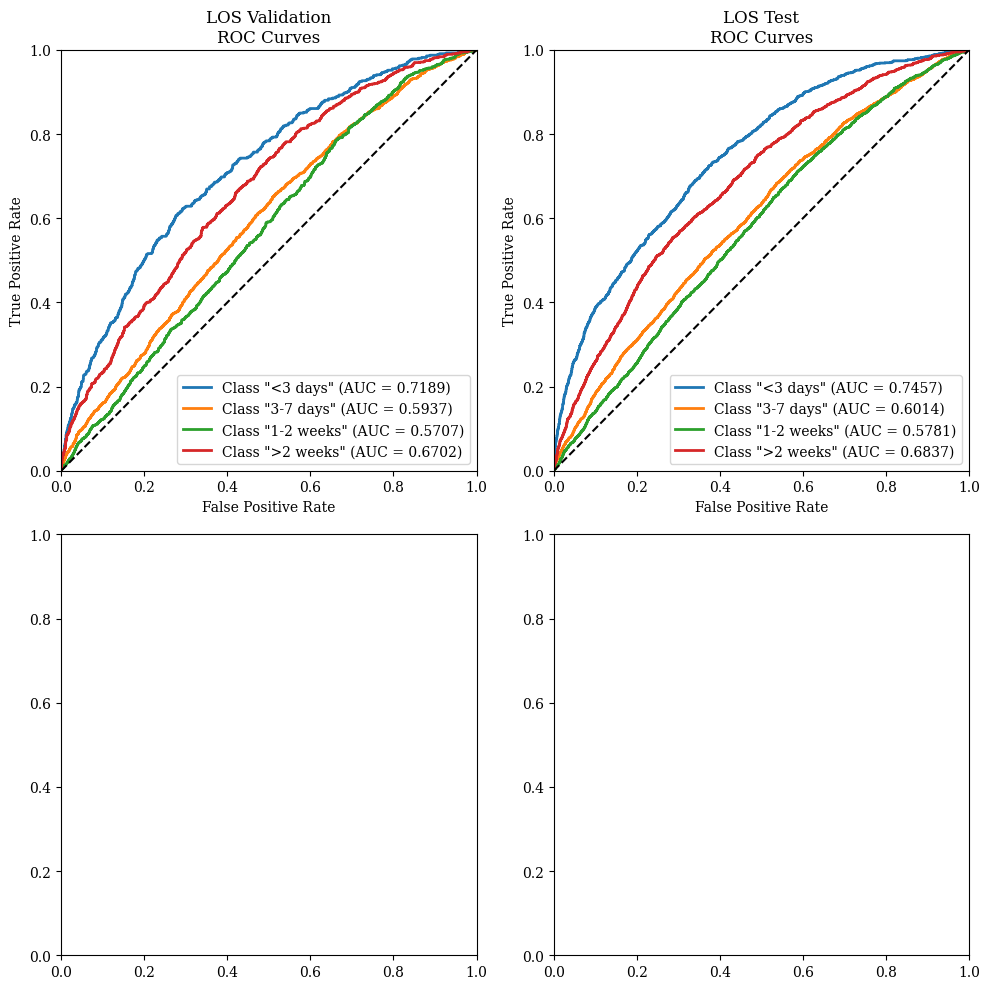

In [24]:
plot_multiclass_roc_pr_curves("los", class_names=["<3 days", "3-7 days", "1-2 weeks", ">2 weeks"])

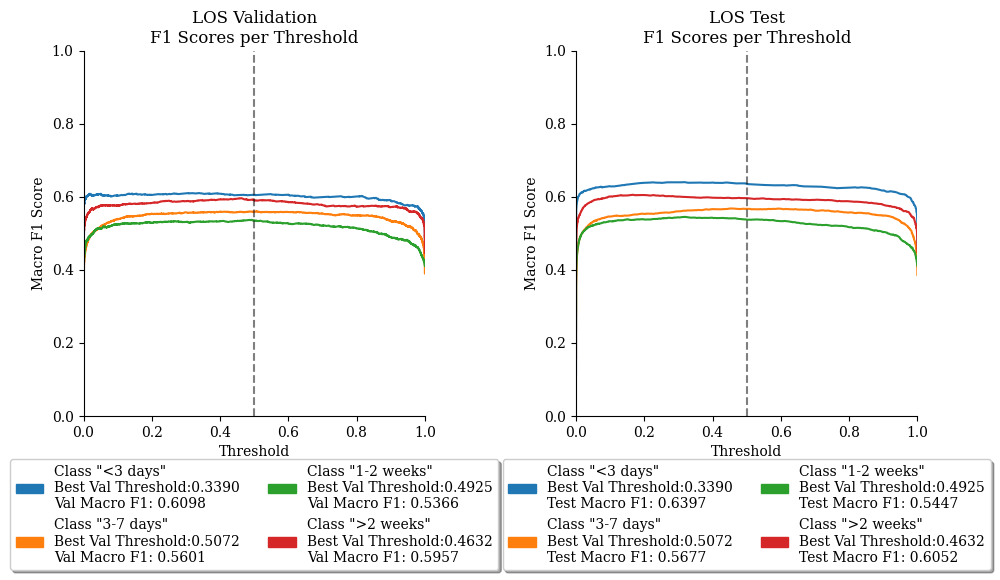

In [565]:
plot_multiclass_f1_scores_per_threshold("los", class_names=["<3 days", "3-7 days", "1-2 weeks", ">2 weeks"])

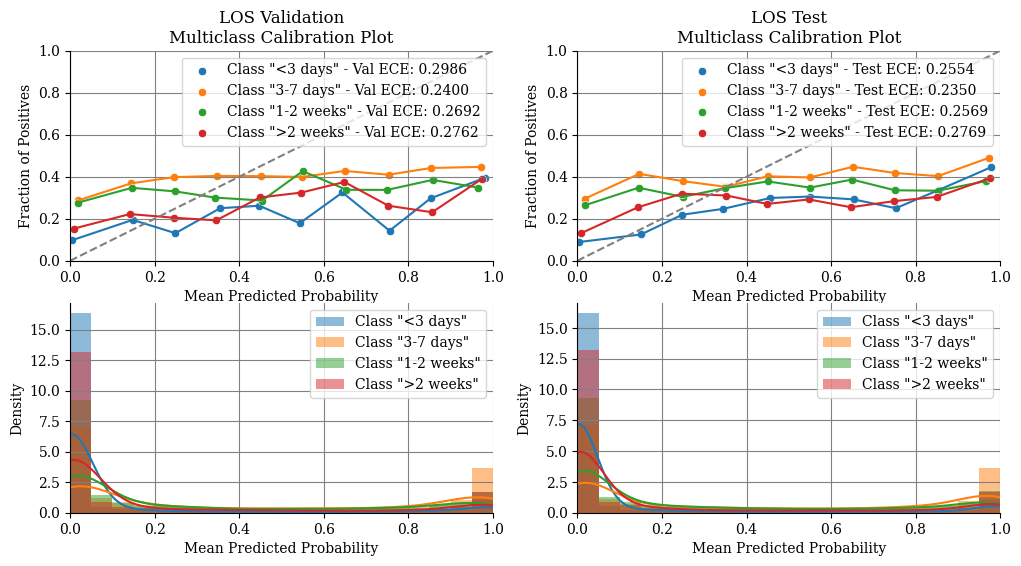

mean_val_ece: 0.27099410471105945
mean_test_ece: 0.2560642794476407


In [525]:
plot_multiclass_calibration_curve("los", class_names=["<3 days", "3-7 days", "1-2 weeks", ">2 weeks"])

In [528]:
sns.set_palette("tab10")

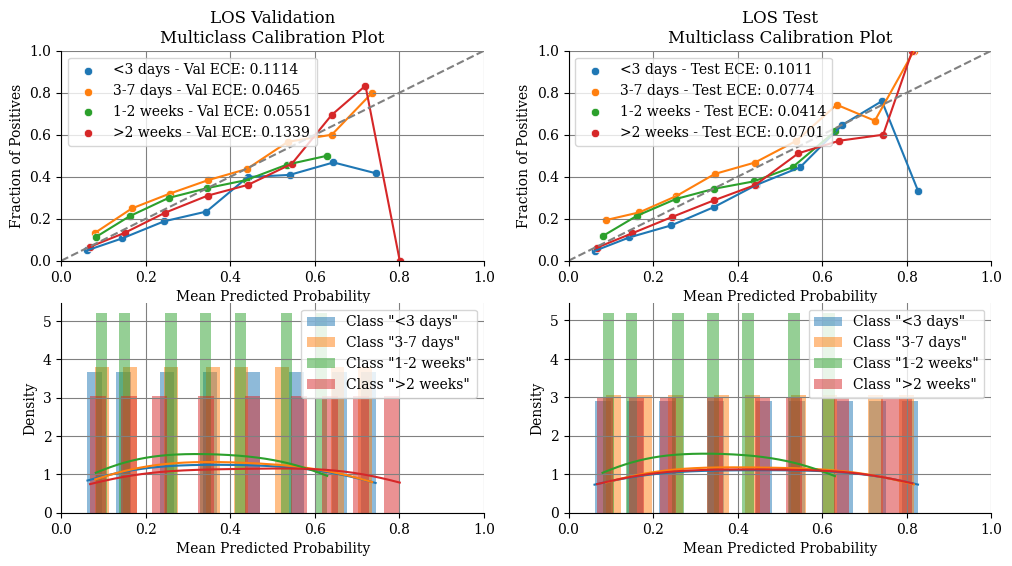

mean_val_ece: 0.08673379168493665
mean_test_ece: 0.07248008761011951


8.999872207641602

In [529]:
temperature_logits_calibrate_multiclass_validation_set("los", class_names=["<3 days", "3-7 days", "1-2 weeks", ">2 weeks"])

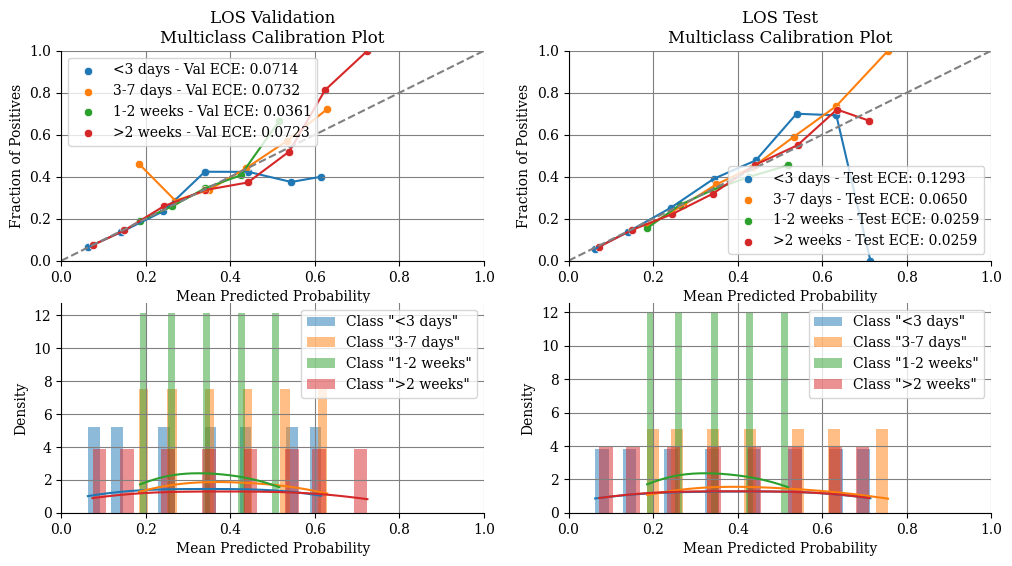

mean_val_ece: 0.06325746700735285
mean_test_ece: 0.06154423474070078


In [538]:
lr_logits_calibrate_multiclass_validation_set("los", class_names=["<3 days", "3-7 days", "1-2 weeks", ">2 weeks"])

# Multilabel Multiclass classification (DIAG, PROC)

# DIAG

In [14]:
def load_full_df(task):
    task_dir = os.path.join(outputs_dir, task)

    # Load data from files
    train_df = pd.read_csv(os.path.join(task_dir, 'train_prediction.csv'))
    val_df = pd.read_csv(os.path.join(task_dir, 'val_prediction.csv'))
    test_df = pd.read_csv(os.path.join(task_dir, 'test_prediction.csv'))

    df = pd.concat([train_df, val_df, test_df])
    return df


def get_columns_with_highest_sum(matrix, num_columns=5):
    # Calculate the sum of each column
    column_sums = [sum(col) for col in zip(*matrix)]

    # Get the indices of the top num_columns columns with the highest sum
    top_column_indices = sorted(range(len(column_sums)), key=lambda i: column_sums[i], reverse=True)[:num_columns]

    return top_column_indices

In [15]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from clinical_peft.constants.diagnoses import DIAGNOSES_MAP

id_2_diagnosis = {v: k for k, v in DIAGNOSES_MAP.items()}

/Users/aryopg/miniconda3/envs/clinical_peft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
df = load_full_df("diag")
groundtruth = np.array([ast.literal_eval(arr) for arr in df['references'].values])

top_5_diagnoses = get_columns_with_highest_sum(groundtruth, num_columns=5)
for diag in top_5_diagnoses:
    print(diag, id_2_diagnosis[diag])

42 401
78 427
5 276
29 272
22 414


# Top 5 diagnoses

- 401: Essential hypertension
- 427: Cardiac dysrhythmias
- 276: Disorders of fluid electrolyte and acid-base balance
- 272: Disorders of lipoid metabolism
- 414: Other forms of chronic ischemic heart disease

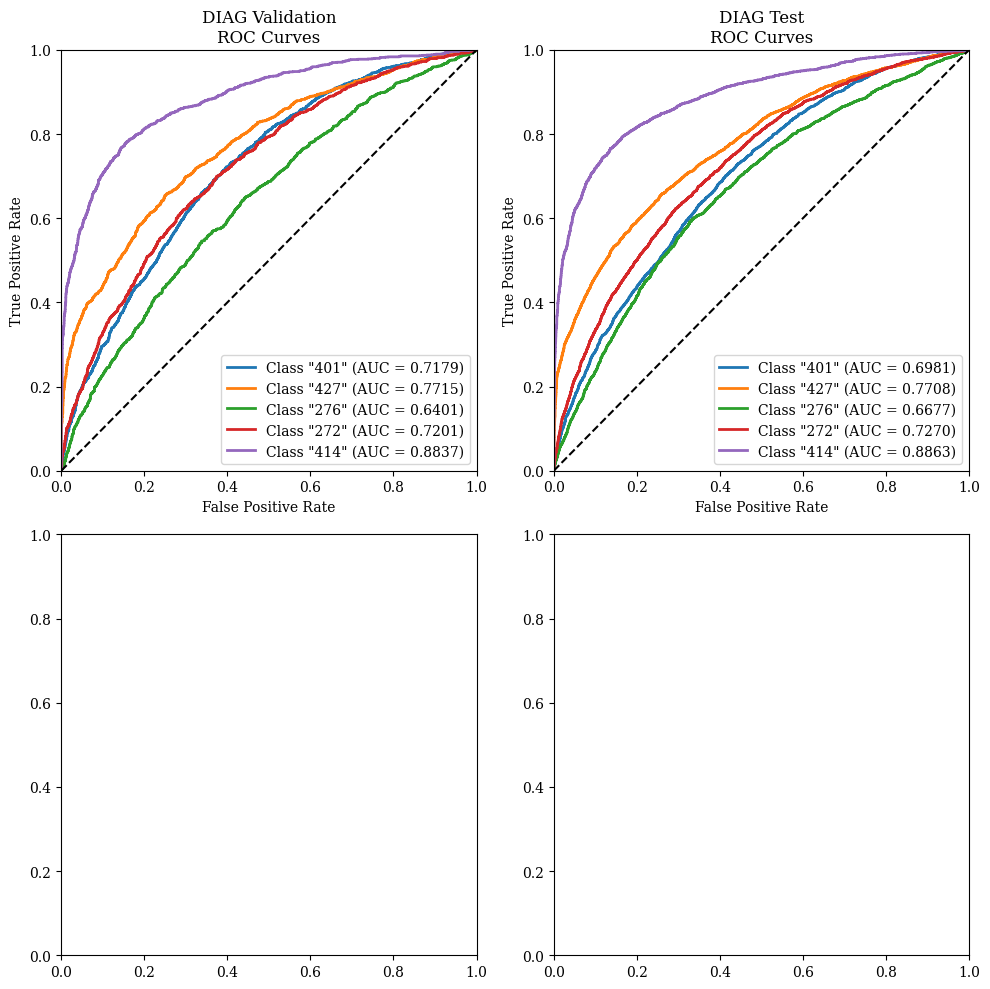

In [27]:
# class_id_map = {
#     42: "Essential hypertension",
#     78: "Cardiac dysrhythmias",
#     5: "Disorders of fluid electrolyte and acid-base balance",
#     29: "Disorders of lipoid metabolism",
#     22: "Other forms of chronic ischemic heart disease",
# }

class_id_map = {
    42: "401",
    78: "427",
    5: "276",
    29: "272",
    22: "414",
}

plot_multiclass_roc_pr_curves("diag", list(class_id_map.keys()), list(class_id_map.values()), multilabel=True)

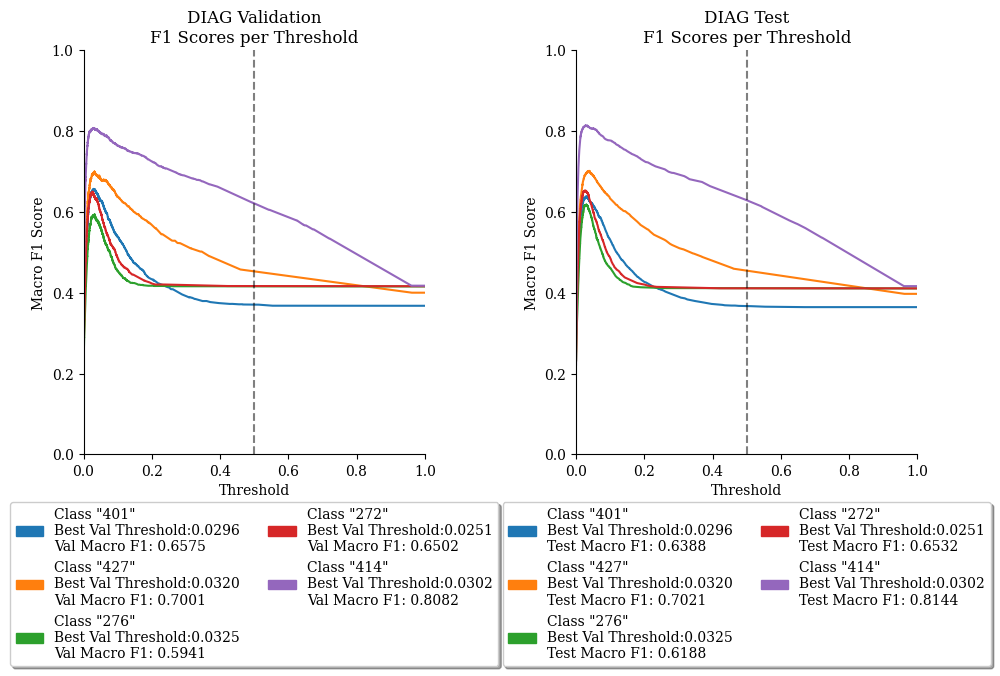

In [569]:
class_id_map = {
    42: "401",
    78: "427",
    5: "276",
    29: "272",
    22: "414",
}

plot_multiclass_f1_scores_per_threshold("diag", list(class_id_map.keys()), list(class_id_map.values()), multilabel=True)

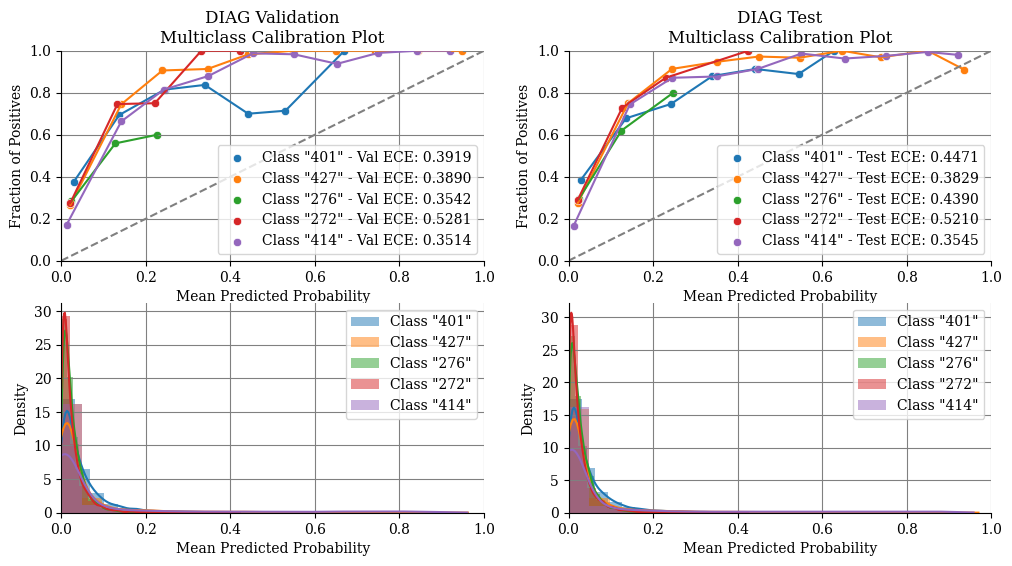

mean_val_ece: 0.4029370726215256
mean_test_ece: 0.4288872740657513


In [531]:
class_id_map = {
    42: "401",
    78: "427",
    5: "276",
    29: "272",
    22: "414",
}

plot_multiclass_calibration_curve("diag", list(class_id_map.keys()), list(class_id_map.values()), multilabel=True)

In [446]:
plot_multiclass_calibration_curve("diag", multilabel=True, to_plot=False)

mean_val_ece: 0.043137457773071514
mean_test_ece: 0.049933592052652194


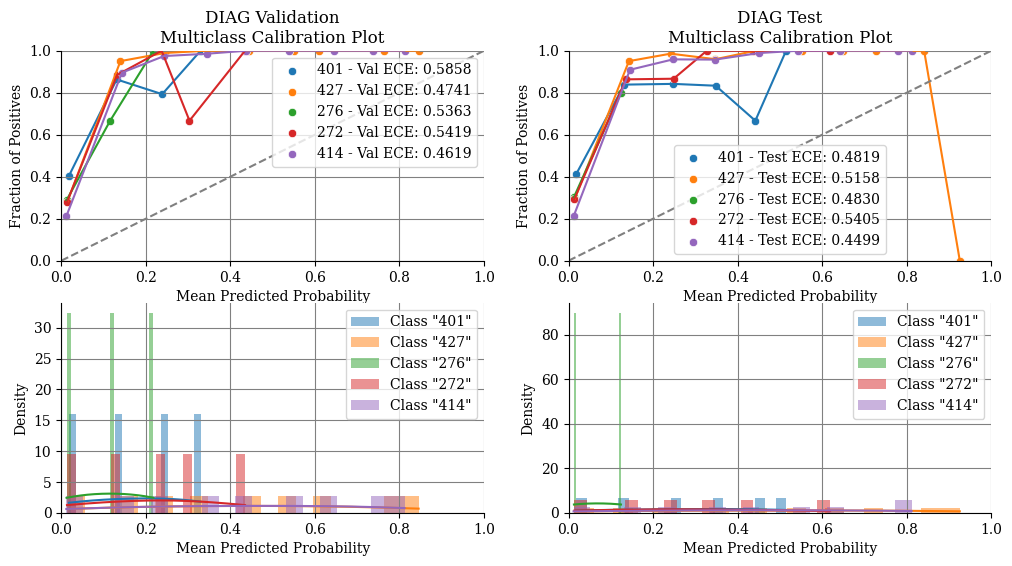

mean_val_ece: 0.5199778619621378
mean_test_ece: 0.4942053303485447


2.1754672527313232

In [532]:
class_id_map = {
    42: "401",
    78: "427",
    5: "276",
    29: "272",
    22: "414",
}

temperature_logits_calibrate_multiclass_validation_set("diag", list(class_id_map.keys()), list(class_id_map.values()), multilabel=True)

In [ ]:
temperature_logits_calibrate_multiclass_validation_set("diag", multilabel=True, to_plot=False)

mean_val_ece: 0.057641972884744035
mean_test_ece: 0.06587897671992457


2.1754672527313232

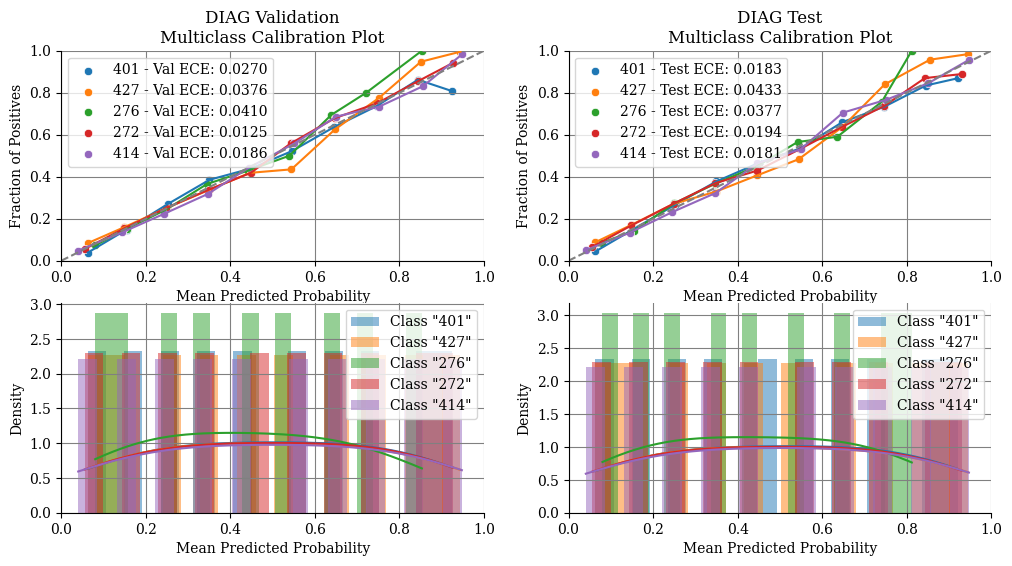

mean_val_ece: 0.027346090797012456
mean_test_ece: 0.02737001462949662


In [539]:
class_id_map = {
    42: "401",
    78: "427",
    5: "276",
    29: "272",
    22: "414",
}

lr_logits_calibrate_multiclass_validation_set("diag", list(class_id_map.keys()), list(class_id_map.values()), multilabel=True)

In [540]:
lr_logits_calibrate_multiclass_validation_set("diag", multilabel=True, to_plot=False)

mean_val_ece: 0.06461506286090557
mean_test_ece: 0.07475428035441727


# PROC

In [21]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from clinical_peft.constants.procedures import PROCEDURES_MAP

id_2_procedure = {v: k for k, v in PROCEDURES_MAP.items()}

In [22]:
df = load_full_df("proc")
groundtruth = np.array([ast.literal_eval(arr) for arr in df['references'].values])

top_5_procedures = get_columns_with_highest_sum(groundtruth, num_columns=5)
for proc in top_5_procedures:
    print(proc, id_2_procedure[proc])

2 389
1 967
25 960
189 990
30 966


# Top 5 Procedures

- 389: Puncture of vessel
- 967: Other continuous invasive mechanical ventilation
- 960: Nonoperative intubation of gastrointestinal and respiratory tracts
- 990: Transfusion of blood and blood components
- 966: Enteral infusion of concentrated nutritional substances

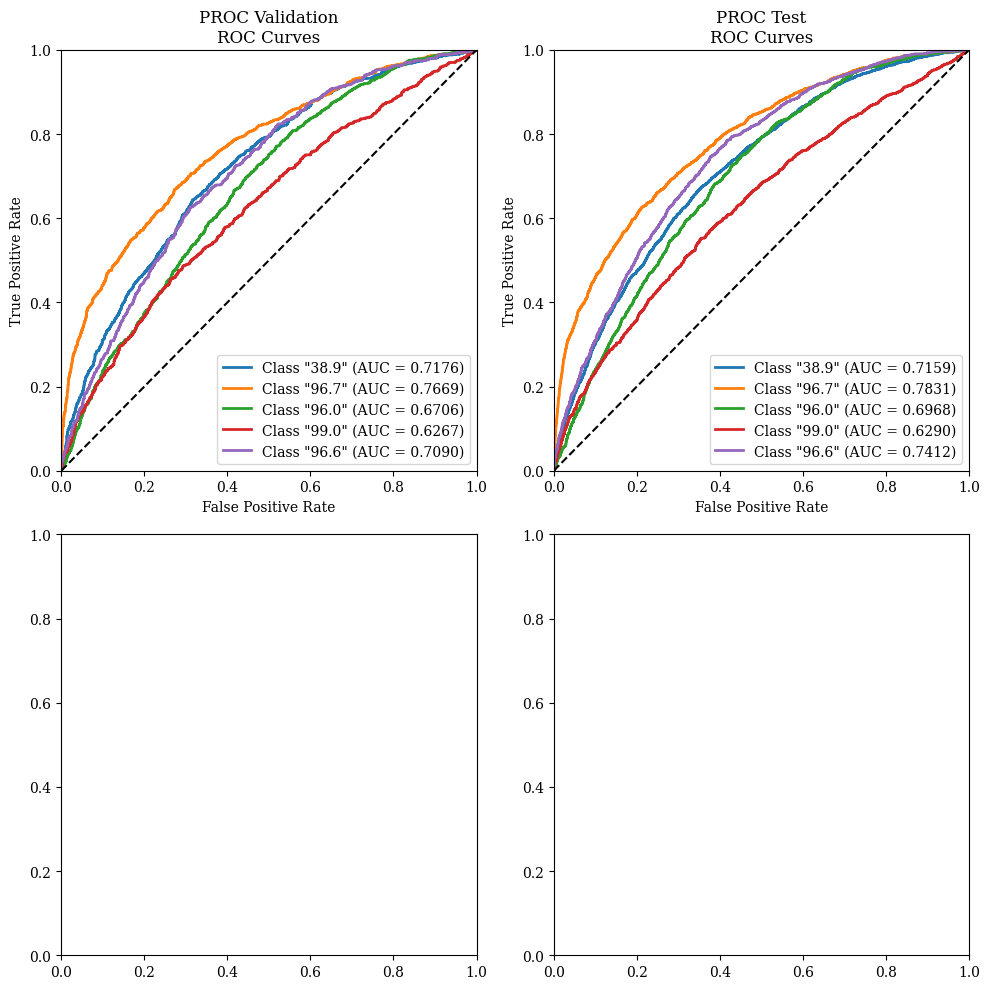

In [29]:
class_id_map = {
    2: "38.9",
    1: "96.7",
    25: "96.0",
    189: "99.0",
    30: "96.6",
}

plot_multiclass_roc_pr_curves("proc", list(class_id_map.keys()), list(class_id_map.values()), multilabel=True)

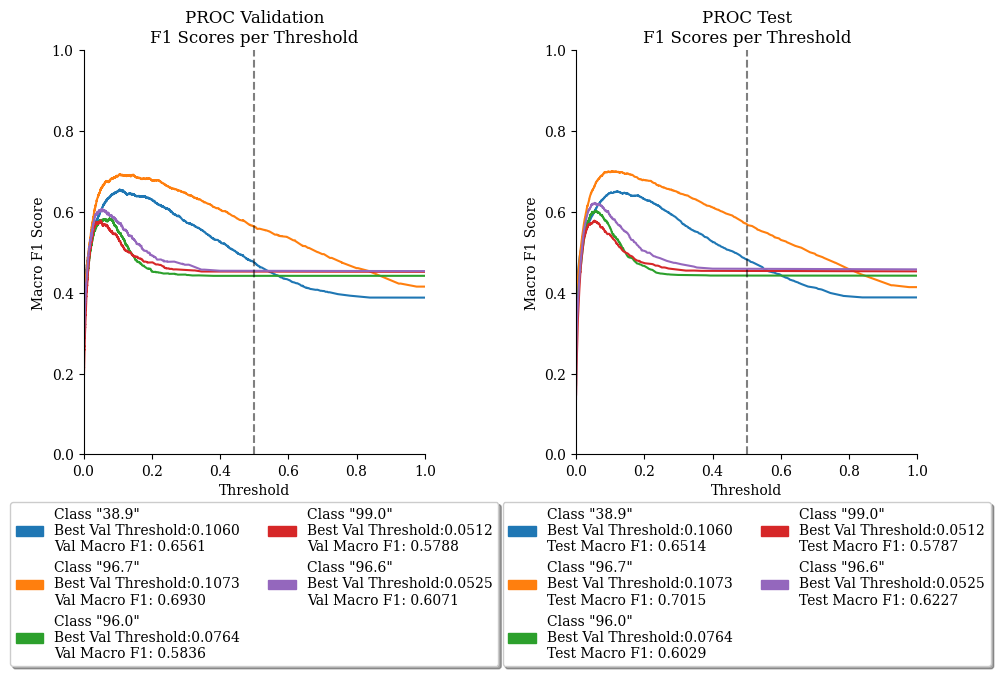

In [570]:
class_id_map = {
    2: "38.9",
    1: "96.7",
    25: "96.0",
    189: "99.0",
    30: "96.6",
}

plot_multiclass_f1_scores_per_threshold("proc", list(class_id_map.keys()), list(class_id_map.values()), multilabel=True)

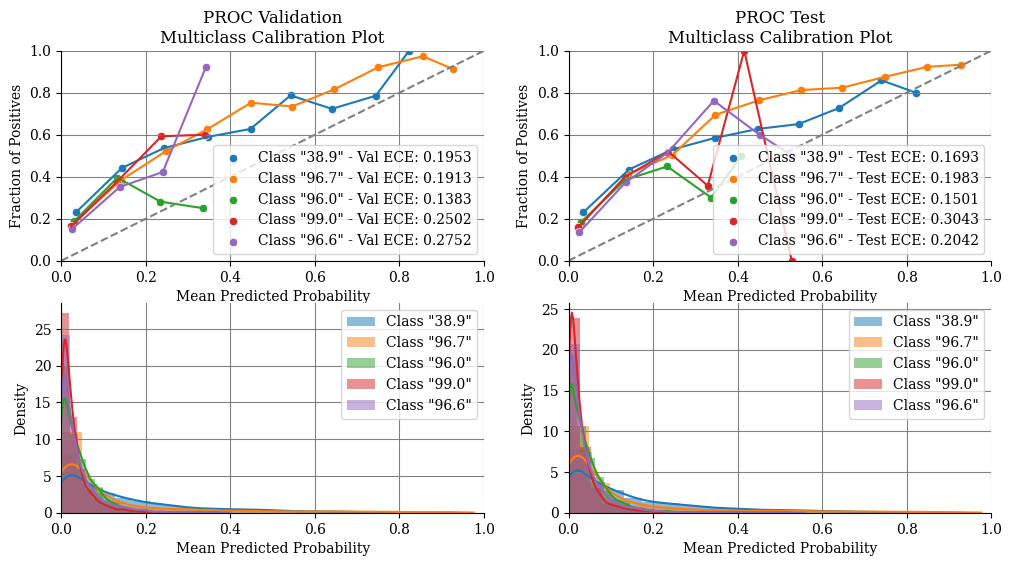

mean_val_ece: 0.21005447191766113
mean_test_ece: 0.20522334620745375


In [534]:
class_id_map = {
    2: "38.9",
    1: "96.7",
    25: "96.0",
    189: "99.0",
    30: "96.6",
}

plot_multiclass_calibration_curve("proc", list(class_id_map.keys()), list(class_id_map.values()), multilabel=True)

In [453]:
plot_multiclass_calibration_curve("proc", multilabel=True, to_plot=False)

mean_val_ece: 0.05758551721082646
mean_test_ece: 0.05992094218027982


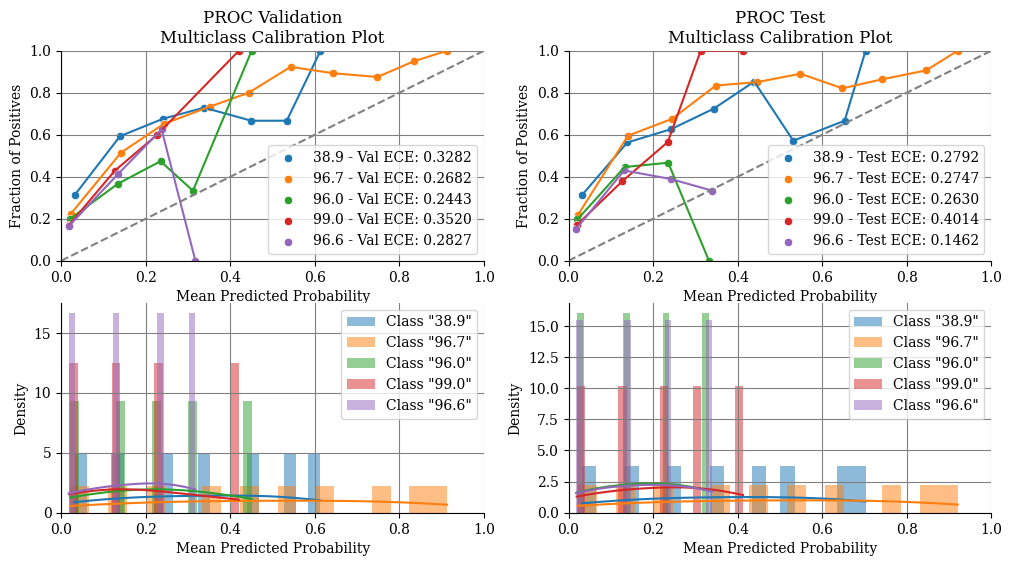

mean_val_ece: 0.29508786090347244
mean_test_ece: 0.2729028205594949


2.3930251598358154

In [535]:
class_id_map = {
    2: "38.9",
    1: "96.7",
    25: "96.0",
    189: "99.0",
    30: "96.6",
}

temperature_logits_calibrate_multiclass_validation_set("proc", list(class_id_map.keys()), list(class_id_map.values()), multilabel=True)

In [454]:
temperature_logits_calibrate_multiclass_validation_set("proc", multilabel=True, to_plot=False)

mean_val_ece: 0.06022427938872581
mean_test_ece: 0.06943931922300171


2.3930251598358154

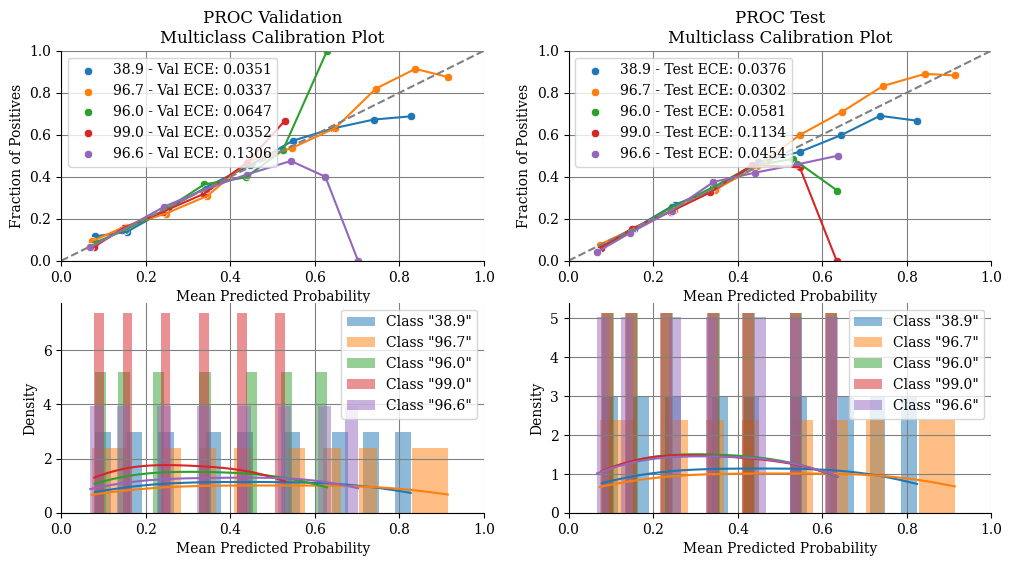

mean_val_ece: 0.05985883144873155
mean_test_ece: 0.05692807459869871


In [536]:
class_id_map = {
    2: "38.9",
    1: "96.7",
    25: "96.0",
    189: "99.0",
    30: "96.6",
}

lr_logits_calibrate_multiclass_validation_set("proc", list(class_id_map.keys()), list(class_id_map.values()), multilabel=True)

In [541]:
lr_logits_calibrate_multiclass_validation_set("proc", multilabel=True, to_plot=False)

mean_val_ece: 0.07301662550922278
mean_test_ece: 0.08094368268730377
